In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys
from tqdm import tqdm
from datetime import datetime

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

from autoencoder import Autoencoder
from solver import test, size_per_epoch, develope_AE, train

In [10]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [11]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-11-13_15-02-06/


In [ ]:
model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
device = torch.device('cuda')

n_epochs = 20
d_explained_variance_ratios = []
d_latent_matrices = []

size_ls = [4,10,16,32]
manner = 'cell_division'

def dev_train_vali_all_epochs(model,size_ls,manner,train_loader,vali_loader,optimizer,n_epochs,device,save_path=None):
	if save_path is None:
		save_path = './'
	else:
		if not os.path.exists(save_path):
			os.makedirs(save_path)
			print('Directory created:', save_path)
	train_losses = []
	all_train_losses = []
	vali_losses = []
	size_each_epoch = size_per_epoch(size_ls,n_epochs,type='step')
	np.save(save_path + 'size_each_epoch.npy',size_each_epoch)
	hyperparam = model.get_hyperparams()

	for epoch in range(n_epochs):
		print(size_each_epoch[epoch])
		model.train()
		# Create new autoencoder with corresponding bottleneck size
		new_n_hidden_ls = np.append(hyperparam['n_hidden_ls'][:-1] , size_each_epoch[epoch])
		if epoch == 0:
			model = Autoencoder(hyperparam['n_input'],new_n_hidden_ls,hyperparam['n_layers'])

		else:
			model = develope_AE(new_n_hidden_ls,hyperparam,save_path=save_path,epoch=epoch,manner=manner)
			optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)
			
		train_loss,train_loss_per_batch = train(model,train_loader,optimizer,epoch,device)
		vali_loss,_,_ = test(model,vali_loader,device)
		train_losses.append(train_loss)
		all_train_losses.append(train_loss_per_batch)
		vali_losses.append(vali_loss)

		# Save the weights of the last epoch.
		torch.save(model.state_dict(), save_path + 'model_weights_epoch{}.pth'.format(epoch))
		print('Weights saved.')

		model.eval()
		latent_list = []

		# Loop through validation data
		with torch.no_grad():  # Gradients not calculated
			for batch_idx, (data, target) in enumerate(test_loader):
				# Convert to a PyTorch variable
				data = Variable(data).to('cpu')

				# Flatten the input data into a 2D tensor [batch_size, num_features]
				batch_size = data.size(0)
				input = data.view(batch_size, -1).to('cpu')

				encoded = model(input)[0]

				latent_list.append(encoded.cpu().numpy())

		latent_matrix = np.concatenate(latent_list)
		print(latent_matrix.shape)
		print(latent_matrix)

		# Perform PCA on number of latent variables available in the bottleneck
		# Max 10 components
		# if size_each_epoch[epoch] < 10:
		# 	pca = PCA(n_components=size_each_epoch[epoch])
		# else:
		# 	pca = PCA(n_components=10)
		pca = PCA(n_components=size_each_epoch[epoch])
		pca.fit(latent_matrix)

		d_explained_variance_ratios.append(pca.explained_variance_ratio_)
		d_latent_matrices.append(pca.components_)

	np.save(save_path + 'all_train_losses.npy',all_train_losses)
	print('All train losses saved.')
	return d_latent_matrices

dev_train_vali_all_epochs(
	model,
	size_ls,
	manner,
	train_loader,
	test_loader,
	optimizer,
	n_epochs,
	device='cpu',
	save_path=save_path+'Dev/{}/'.format(manner)
	)

Directory created: /home/david/sparsify_models/AE/MNIST/2024-11-13_15-02-06/Dev/cell_division/
4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001270: 100%|██████████| 469/469 [00:03<00:00, 130.15it/s]


====> Epoch: 0 Average loss: 0.1209


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1231
Weights saved.
(10000, 4)
[[ 0.03976813 -0.14322719  0.01641365  0.05315186]
 [ 0.18037608 -0.01603721 -0.02184473  0.03695457]
 [ 0.04034937 -0.02518953  0.02244101  0.02068543]
 ...
 [-0.00776554 -0.10934258 -0.02400127 -0.04029288]
 [ 0.01854848 -0.05751562  0.02595196 -0.06405675]
 [-0.03199896 -0.1163262  -0.0363098  -0.08217915]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0580



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0487
Weights saved.
(10000, 10)
[[-0.5823865  -0.03694578 -0.03323022 ...  0.12272938  0.04042559
  -0.12310228]
 [ 0.507982   -0.14411885  0.3066577  ... -0.27252284  0.04417395
   0.13427594]
 [ 0.29100794  0.35323387  0.08040509 ...  0.09102724  0.06625042
   0.02984032]
 ...
 [-0.46769354 -0.0444571   0.6372828  ...  0.26687652  0.00861802
  -0.01237252]
 [-0.24032146  0.2987215   0.4606257  ... -0.1451051   0.04285775
   0.01554964]
 [-0.13517028 -0.4334677   0.713377   ... -0.51316863 -0.08942369
   0.09993707]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0466


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0431
Weights saved.
(10000, 16)
[[-0.55720377 -0.01793002 -0.06842181 ...  0.01551199  0.11077158
   0.11215483]
 [ 0.47932896 -0.1169584   0.22113843 ...  0.17019263  0.07241835
   0.11104508]
 [ 0.27317548  0.35523465  0.09285301 ...  0.00429399 -0.02323733
  -0.05307555]
 ...
 [-0.43982276 -0.07201586  0.546898   ...  0.21094055  0.12912464
   0.15102577]
 [-0.22549349  0.32027078  0.38293427 ...  0.15143135  0.11177534
   0.12745953]
 [-0.24928465 -0.42108515  0.83208877 ... -0.08733057 -0.3415823
  -0.20202842]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0398



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0357
Weights saved.
(10000, 32)
[[-0.3323891   0.00325931 -0.01736416 ... -0.22650437  0.05468109
   0.10639974]
 [ 0.2941424  -0.0628686   0.10859745 ...  0.12084435  0.00061578
   0.12481793]
 [ 0.16943392  0.21857208  0.0481618  ...  0.02379546 -0.15472417
  -0.13174382]
 ...
 [-0.26881173 -0.07402192  0.36376554 ...  0.13464561 -0.06503157
  -0.09365157]
 [-0.14006352  0.18728392  0.22555295 ...  0.10280302  0.02218773
   0.01749438]
 [-0.14033946 -0.28095824  0.5005286  ...  0.11814357 -0.4196734
  -0.03603283]]
All train losses saved.


[array([[-0.03443561,  0.6885028 ,  0.4121044 ,  0.5957752 ],
        [-0.42610484, -0.5824243 ,  0.6663773 ,  0.18750454],
        [ 0.48448738,  0.16553667,  0.62136686, -0.59310436],
        [ 0.7632305 , -0.3991785 , -0.0038085 ,  0.5080563 ]],
       dtype=float32),
 array([[ 0.37414366,  0.44340315,  0.1122586 ,  0.38015634,  0.38178566,
          0.44063854,  0.10778928,  0.38675654,  0.03923544,  0.06023418],
        [-0.31511372, -0.14857326, -0.24254455,  0.565147  , -0.31614608,
         -0.1525876 , -0.2395013 ,  0.55814743, -0.01360272, -0.09002554],
        [-0.4654767 ,  0.51370233,  0.00188307, -0.1303015 , -0.46339265,
          0.5126634 ,  0.00424462, -0.12758939,  0.02513354, -0.08929739],
        [-0.18679938, -0.12985069,  0.65179676,  0.14664492, -0.18404117,
         -0.12969607,  0.65237474,  0.14168113, -0.05516866,  0.04998886],
        [-0.00736997,  0.02663288,  0.03285597, -0.02602515,  0.03383887,
         -0.10945983,  0.06326271,  0.02645222,  0.9266974

In [24]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

# Epoch pairs: [(0, 1), (1, 2), ..., (epochs - 1, epochs)]
all_epoch_pairs = [(i, i + 1) for i in range(n_epochs - 1)]

In [14]:
target_dim = 32

def pad_latent_matrices(d_latent_matrices, target_dim):
    padded_data = []
    for matrices in d_latent_matrices:
        padded_matrices = []
        for matrix in matrices:
            padded_matrix = np.pad(matrix, (0, target_dim - matrix.shape[0]), 'constant')
            padded_matrices.append(padded_matrix)
        while len(padded_matrices) < target_dim:
            padded_matrices.append(np.zeros(padded_matrices[0].shape))
        padded_data.append(padded_matrices)
    return np.array(padded_data)

padded_data = pad_latent_matrices(d_latent_matrices, target_dim)

In [16]:
def angle_between_pcs(padded_data, all_epoch_pairs):
    padded_angle_dict = {}
    for pc in range(size_ls[-1]):
        if pc not in padded_angle_dict:
            padded_angle_dict[pc] = {}
        for epoch_pair in all_epoch_pairs:
            angle = cosine_angle_between_pcs(padded_data[epoch_pair[0]][pc], padded_data[epoch_pair[1]][pc])
            padded_angle_dict[pc][epoch_pair] = angle
    return padded_angle_dict

padded_angle_dict = angle_between_pcs(padded_data, all_epoch_pairs)

/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [19]:
def plot_heatmap(padded_angle_dict, all_epoch_pairs, k):
    angle_matrix = np.zeros((len(padded_angle_dict), len(all_epoch_pairs)))

    # Fill matrix with angle data
    for pc, epoch_data in padded_angle_dict.items():
        i = 0
        for epoch_pair in all_epoch_pairs:
            angle_matrix[pc, i] = epoch_data[epoch_pair]
            i += 1

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        angle_matrix, 
        annot=True, 
        fmt=".0f",
        norm=LogNorm(), 
        xticklabels=[f"{e1}-{e2}" for e1, e2 in all_epoch_pairs], 
        yticklabels=[f"PC{pc}" for pc in padded_angle_dict.keys()],
        cbar_kws={"label": "Angle between PCs"})
    ax.set_title("Stability of PCs over training epochs (padded)")
    plt.savefig(f'Stability_DAE_Plots/Stability_Plot_{k}.png')

4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001336: 100%|██████████| 469/469 [00:03<00:00, 124.60it/s]


====> Epoch: 0 Average loss: 0.1258


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1282
Weights saved.
(10000, 4)
[[ 0.02986668 -0.112261   -0.00915949  0.12879178]
 [ 0.06166907 -0.08167648 -0.02176755  0.02499153]
 [ 0.03860321  0.01103299  0.01500293  0.02083083]
 ...
 [ 0.17947318 -0.12588571  0.03011909  0.1512869 ]
 [ 0.07032058 -0.08038704 -0.03810485 -0.00151128]
 [ 0.1326667  -0.0676132   0.09648276  0.1491158 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0605



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0487
Weights saved.
(10000, 4)
[[-0.5146701  -0.44850874 -0.5116202   0.4984715 ]
 [ 0.5084627   0.09341262  1.091506    0.20846233]
 [ 0.4303884   0.6486428  -0.10009118  0.15106907]
 ...
 [-0.35253987 -0.2084611  -0.3728817   1.2412459 ]
 [-0.08490971  0.25626567  0.06951172  0.7607007 ]
 [-1.0337901   0.32573056  1.5882431   0.06306921]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.4512781  -0.4720895  -0.50176203  0.5126695 ]
 [ 0.50538474  0.2608608   1.1077906   0.19939895]
 [ 0.49548185  0.5978575  -0.1194215   0.17666818]
 ...
 [-0.4180413  -0.2767436  -0.48872137  1.1868736 ]
 [-0.1682155   0.4301701   0.01662205  0.8757661 ]
 [-1.2282444   0.54272014  1.4726272   0.06697397]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0483


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.42074734 -0.5011139  -0.5017504   0.5284257 ]
 [ 0.46935242  0.3261816   1.11274     0.16834101]
 [ 0.5146492   0.5722327  -0.12155396  0.18225253]
 ...
 [-0.43481034 -0.24857098 -0.50255454  1.1346353 ]
 [-0.19322999  0.4742169   0.00753487  0.9082475 ]
 [-1.2912853   0.6318536   1.4570684   0.020419  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0482



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0479
Weights saved.
(10000, 4)
[[-0.40968865 -0.5167775  -0.51144046  0.53296465]
 [ 0.455891    0.36116517  1.1184222   0.13488792]
 [ 0.5227003   0.56012875 -0.11816332  0.18542193]
 ...
 [-0.45546323 -0.21731845 -0.49222428  1.0652093 ]
 [-0.20119877  0.4921917   0.0055135   0.9119913 ]
 [-1.3192776   0.6798176   1.4719197  -0.03313401]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0478
Weights saved.
(10000, 10)
[[-0.21446021 -0.31745806 -0.31178716 ...  0.28809083 -0.12563717
  -0.08124954]
 [ 0.26568455  0.22036213  0.66906095 ...  0.04452316 -0.05934963
   0.01954035]
 [ 0.33784142  0.33850583 -0.0957322  ...  0.05722325 -0.11000026
  -0.02741957]
 ...
 [-0.27686453 -0.11440175 -0.2874898  ...  0.613614   -0.05023859
   0.09100336]
 [-0.11659475  0.29346806 -0.00604348 ...  0.54098433 -0.08449387
   0.0213101 ]
 [-0.80520904  0.4297878   0.8930645  ... -0.03915907 -0.0839421
   0.06473278]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0465


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0446
Weights saved.
(10000, 10)
[[-0.23929168 -0.329443   -0.2982346  ...  0.30525848 -0.23519072
  -0.21562281]
 [ 0.273776    0.2457466   0.64497304 ...  0.05611263  0.07242292
   0.32910308]
 [ 0.3309057   0.3299512  -0.08779752 ...  0.07680984 -0.18654123
  -0.05821218]
 ...
 [-0.25526822 -0.03848483 -0.34248996 ...  0.6003578   0.18436986
   0.80507123]
 [-0.11930068  0.31083676 -0.0116628  ...  0.56096554 -0.07333623
   0.2009866 ]
 [-0.788814    0.4723391   0.8552102  ... -0.03792653  0.00801063
   0.5557505 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0441


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0426
Weights saved.
(10000, 10)
[[-0.23436955 -0.2995834  -0.30980602 ...  0.2550912  -0.45661303
  -0.08051857]
 [ 0.2765569   0.26281065  0.6484269  ...  0.03657374 -0.01096125
   0.3656622 ]
 [ 0.32583755  0.34481674 -0.08537652 ...  0.03227726 -0.45294973
   0.01948491]
 ...
 [-0.26050153 -0.01751713 -0.34911686 ...  0.55240643 -0.05596274
   0.9020792 ]
 [-0.12073405  0.33428618 -0.01035096 ...  0.5370283  -0.28727865
   0.2666448 ]
 [-0.7888713   0.50625366  0.8485932  ... -0.09230857 -0.33403063
   0.74928534]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0428


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0422
Weights saved.
(10000, 10)
[[-0.22966865 -0.2900706  -0.31021476 ...  0.23590225 -0.5533217
  -0.04240167]
 [ 0.27665922  0.27122054  0.6510823  ...  0.05920473  0.02181886
   0.36963418]
 [ 0.3269212   0.34766382 -0.08266161 ...  0.02878922 -0.45605433
   0.01843002]
 ...
 [-0.25582305 -0.01527242 -0.35126734 ...  0.52462184 -0.16332066
   0.92060626]
 [-0.12082649  0.34101382 -0.00428821 ...  0.554983   -0.21134332
   0.24365404]
 [-0.78846055  0.5064577   0.8446585  ... -0.05309678 -0.16885723
   0.72637165]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0424



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0419
Weights saved.
(10000, 10)
[[-0.23013414 -0.28448647 -0.31328204 ...  0.23136224 -0.5805073
  -0.02838722]
 [ 0.2868476   0.2621738   0.64147866 ...  0.0790558   0.15390615
   0.34575996]
 [ 0.32874995  0.34855023 -0.08396411 ...  0.03281368 -0.4029401
  -0.00163576]
 ...
 [-0.25522166 -0.0144991  -0.36343157 ...  0.51263803 -0.21897718
   0.9264151 ]
 [-0.10523054  0.33181626 -0.0123958  ...  0.57411826 -0.08536974
   0.20230135]
 [-0.7788879   0.49748614  0.8376704  ... -0.01439058  0.10980275
   0.6676644 ]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0422


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 16)
[[-0.2256176  -0.29878643 -0.31887794 ... -0.06510536 -0.03035662
  -0.07511331]
 [ 0.28713903  0.26009187  0.64010054 ... -0.04620831  0.02215784
  -0.01965022]
 [ 0.3313799   0.3361671  -0.08061852 ... -0.05438465 -0.03822364
  -0.07138838]
 ...
 [-0.24773745 -0.01496049 -0.35956323 ... -0.00764793  0.01326061
  -0.04217661]
 [-0.11036175  0.33619967 -0.01280511 ... -0.03238964  0.03028024
  -0.04014873]
 [-0.7640491   0.49482715  0.84457165 ... -0.05436813  0.03999257
  -0.050056  ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0411



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0391
Weights saved.
(10000, 16)
[[-2.3399219e-01 -2.5477007e-01 -3.0888271e-01 ... -3.7996307e-02
   9.4001614e-02 -7.6353937e-02]
 [ 2.8395906e-01  3.1092089e-01  6.5591425e-01 ... -9.8373726e-02
   1.3492823e-01 -7.6913029e-02]
 [ 3.2742512e-01  3.7211117e-01 -6.8101928e-02 ... -9.8662823e-02
   1.4613867e-03 -1.3679405e-01]
 ...
 [-2.4181437e-01 -2.3693275e-02 -3.4873801e-01 ... -3.6349751e-02
  -3.5777826e-02 -1.1568661e-01]
 [-1.2049508e-01  3.9423144e-01  1.6480684e-05 ... -2.8722432e-02
   1.9701052e-01 -6.0914837e-02]
 [-7.6520497e-01  5.6537187e-01  8.6819935e-01 ... -2.6652390e-01
   9.3821071e-02 -3.1149033e-01]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0381



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0366
Weights saved.
(10000, 16)
[[-0.2333411  -0.21633723 -0.3062489  ...  0.05984036  0.2381864
  -0.02253016]
 [ 0.29201838  0.33638808  0.6519204  ... -0.13255312  0.22186603
   0.01539668]
 [ 0.33388937  0.3690096  -0.06431456 ... -0.09636477 -0.03219832
  -0.13545361]
 ...
 [-0.2503718  -0.02181559 -0.32094303 ...  0.05969277 -0.11114496
  -0.28961974]
 [-0.11449005  0.41222024  0.00188542 ...  0.03894822  0.274534
   0.02924026]
 [-0.75627065  0.5646148   0.8773594  ... -0.45203584  0.00623773
  -0.43708658]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0360



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0343
Weights saved.
(10000, 16)
[[-0.23426944 -0.20042306 -0.2887013  ...  0.15449058  0.4075144
  -0.12548462]
 [ 0.29341078  0.324166    0.6416237  ... -0.09597     0.2295725
   0.17909078]
 [ 0.3414036   0.3590013  -0.06260045 ...  0.03036948 -0.14549334
  -0.09362777]
 ...
 [-0.23903263 -0.01652364 -0.295945   ...  0.35869417 -0.11461102
  -0.40378767]
 [-0.10932659  0.3963813   0.00114    ...  0.0941827   0.22783774
   0.12360476]
 [-0.746971    0.5632751   0.8697756  ... -0.4930933  -0.02040846
  -0.38466316]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0335


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0321
Weights saved.
(10000, 16)
[[-0.22704008 -0.19038479 -0.27348906 ...  0.14874518  0.7097019
  -0.19823167]
 [ 0.29436457  0.31849733  0.6503417  ... -0.08776478  0.43962523
   0.28502655]
 [ 0.34515628  0.366106   -0.06543247 ...  0.09252167 -0.29394445
  -0.12742218]
 ...
 [-0.2212027  -0.01200118 -0.29835558 ...  0.57285756 -0.26301488
  -0.4839594 ]
 [-0.10318942  0.38164267 -0.00104833 ...  0.14405394  0.21363553
   0.2165573 ]
 [-0.74451786  0.56724375  0.8655675  ... -0.45991886 -0.06674632
  -0.37843   ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0329


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.12144075 -0.10983551 -0.15016577 ...  0.05951905  0.4580567
  -0.13580392]
 [ 0.17010608  0.19092226  0.41304344 ... -0.00940615  0.38485733
   0.2070038 ]
 [ 0.23559362  0.2335524  -0.02267403 ...  0.01286458 -0.20632617
  -0.13764755]
 ...
 [-0.1323638  -0.01339216 -0.16261166 ...  0.37563547 -0.1972653
  -0.2808495 ]
 [-0.06014251  0.22958887  0.02519125 ...  0.1298483   0.12200212
   0.12227536]
 [-0.44420198  0.3477439   0.5542048  ... -0.2502269  -0.03788264
  -0.20960775]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.12043703 -0.10577848 -0.15061744 ...  0.05048528  0.47799134
  -0.13576707]
 [ 0.17024261  0.19563589  0.4131346  ...  0.00178313  0.4166572
   0.19392738]
 [ 0.23651     0.23580678 -0.0225141  ...  0.0027807  -0.20124103
  -0.1451083 ]
 ...
 [-0.13075979 -0.01365931 -0.16446212 ...  0.3884281  -0.21162458
  -0.27621093]
 [-0.05795282  0.23767985  0.0263103  ...  0.1433834   0.09358492
   0.07458515]
 [-0.4422385   0.34473798  0.550404   ... -0.23931393 -0.04523391
  -0.19770813]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.11773266 -0.10455257 -0.15106553 ...  0.04483863  0.48373842
  -0.13831991]
 [ 0.17527533  0.1965357   0.4093172  ...  0.00621061  0.41479874
   0.16905856]
 [ 0.23609817  0.23653439 -0.02103386 ... -0.00240906 -0.19595641
  -0.14379598]
 ...
 [-0.1276552  -0.01217406 -0.1660077  ...  0.39304322 -0.21054345
  -0.27198786]
 [-0.05215663  0.2467073   0.02350454 ...  0.15018222  0.06492662
   0.02696272]
 [-0.4420581   0.34078613  0.5462493  ... -0.23330386 -0.04381302
  -0.18378145]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0318


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.11851843 -0.10058425 -0.15229297 ...  0.03910068  0.48503706
  -0.1451996 ]
 [ 0.17504075  0.20232308  0.40773875 ...  0.00808652  0.3921029
   0.13587052]
 [ 0.23722222  0.2373749  -0.02168871 ... -0.00761669 -0.18885455
  -0.13808037]
 ...
 [-0.1250327  -0.01155952 -0.16587509 ...  0.39536482 -0.20437361
  -0.2657674 ]
 [-0.04898743  0.2546086   0.02487775 ...  0.15537876  0.03343395
  -0.01708956]
 [-0.43781096  0.34154934  0.54386514 ... -0.23374748 -0.03804182
  -0.17321323]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.11681677 -0.09771531 -0.1527834  ...  0.03841992  0.48067302
  -0.15227498]
 [ 0.17460197  0.206241    0.40432492 ...  0.01004772  0.36596674
   0.10174347]
 [ 0.23862591  0.23763345 -0.02159954 ... -0.00981157 -0.18193747
  -0.12881334]
 ...
 [-0.12362344 -0.01168401 -0.1670683  ...  0.39584628 -0.20209728
  -0.26024023]
 [-0.04929603  0.2604874   0.02181184 ...  0.15863144  0.00094257
  -0.06031246]
 [-0.43659034  0.33836055  0.53935105 ... -0.23067012 -0.03409095
  -0.15977146]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001286: 100%|██████████| 469/469 [00:03<00:00, 126.15it/s]

====> Epoch: 0 Average loss: 0.1220



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1243
Weights saved.
(10000, 4)
[[-0.0416273  -0.05923522  0.13079299 -0.01820239]
 [ 0.05409547 -0.06750144  0.09115519 -0.02799293]
 [-0.03603567 -0.05638478  0.0439201  -0.05328942]
 ...
 [-0.05228558 -0.06444845  0.0849547  -0.11070888]
 [-0.03366634 -0.07190232  0.06579947 -0.09858751]
 [-0.05983605  0.01226978  0.02650599 -0.0390539 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0610



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0508
Weights saved.
(10000, 4)
[[-0.49632823 -0.4957923   0.25934216 -0.6067555 ]
 [ 0.7803597  -0.19974199  0.59625864  0.77807564]
 [ 0.15320247 -0.18074617 -0.452911    0.15037607]
 ...
 [ 0.07188191 -1.3448564   0.2958734  -0.13354619]
 [-0.27858755 -1.1556352  -0.00239985  0.16034721]
 [-0.29063728 -0.55931735  1.4476421   1.498505  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0493


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0484
Weights saved.
(10000, 4)
[[-0.6946078  -0.42124635  0.23756039 -0.87674505]
 [ 0.9854247  -0.20866974  0.6283621   0.8677416 ]
 [ 0.34115657 -0.21702309 -0.46632773  0.23422618]
 ...
 [-0.32414258 -1.3288368   0.21722475 -0.37110627]
 [-0.14780678 -1.1535145   0.02301799  0.14990918]
 [-0.28352472 -0.69460803  1.4261175   1.5637423 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0484



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.7087327  -0.40780818  0.22258645 -0.8766777 ]
 [ 0.9434667  -0.18726254  0.62926304  0.7496091 ]
 [ 0.38979757 -0.2535282  -0.46320844  0.25896937]
 ...
 [-0.5756446  -1.1672273   0.1905778  -0.6068702 ]
 [-0.13794559 -1.1539645   0.03555558  0.08150795]
 [-0.38309652 -0.6572328   1.4253398   1.3222003 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.7108477  -0.41501188  0.21282382 -0.8678096 ]
 [ 0.9165062  -0.14940025  0.6287603   0.68638843]
 [ 0.3910103  -0.26560563 -0.4677927   0.24620456]
 ...
 [-0.6551136  -1.053624    0.18417881 -0.67240256]
 [-0.14612566 -1.1442893   0.04040016  0.04106801]
 [-0.4274206  -0.6011031   1.4299569   1.2205863 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0484



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0468
Weights saved.
(10000, 10)
[[-0.44113034 -0.2457284   0.1292052  ... -0.50560856 -0.06848374
  -0.02956977]
 [ 0.5337108  -0.07231405  0.36084914 ...  0.41242662 -0.2078994
   0.09664556]
 [ 0.22294006 -0.12705803 -0.33099234 ...  0.16891406 -0.09701432
  -0.03764421]
 ...
 [-0.42250687 -0.5793057   0.1192137  ... -0.37094983 -0.37254158
   0.25504696]
 [-0.10333413 -0.6909677   0.0315467  ...  0.04166577 -0.16058949
   0.05359197]
 [-0.27340797 -0.38348982  0.89823776 ...  0.7214141  -0.26303965
   0.18514797]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0456



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0446
Weights saved.
(10000, 10)
[[-4.5011953e-01 -2.6909351e-01  1.4216304e-01 ... -5.2309251e-01
  -7.2000921e-04 -5.4686129e-02]
 [ 5.2361500e-01 -6.3799843e-02  3.5037333e-01 ...  4.0557036e-01
  -3.6051649e-01  2.4082416e-01]
 [ 2.2095326e-01 -1.5299824e-01 -3.1123784e-01 ...  1.5076670e-01
  -5.3032368e-02 -8.0512598e-02]
 ...
 [-4.4046822e-01 -5.1334143e-01  8.1932105e-02 ... -3.4240606e-01
  -8.2910627e-01  6.3674587e-01]
 [-1.0798532e-01 -6.9576728e-01  3.3941008e-02 ...  2.5076337e-02
  -2.4651708e-01  1.3249078e-01]
 [-2.7530745e-01 -3.6964536e-01  8.8277262e-01 ...  7.1905142e-01
  -4.8347211e-01  4.0472579e-01]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0448



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0437
Weights saved.
(10000, 10)
[[-0.43938777 -0.2738053   0.14464009 ... -0.5435567   0.2028392
   0.0944694 ]
 [ 0.5273174  -0.05553243  0.3437016  ...  0.40649122 -0.29987103
   0.26888236]
 [ 0.22332661 -0.1429852  -0.31813914 ...  0.14880514  0.03340353
  -0.05911195]
 ...
 [-0.44458595 -0.50010824  0.05439541 ... -0.31883836 -1.0504035
   0.47866115]
 [-0.10365877 -0.68391323  0.02889709 ...  0.02822577 -0.18720292
   0.1322312 ]
 [-0.28718573 -0.34826204  0.8714805  ...  0.7199711  -0.39367354
   0.46296838]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0432


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0423
Weights saved.
(10000, 10)
[[-0.4388551  -0.27080908  0.15001294 ... -0.5550018   0.41459376
   0.27781352]
 [ 0.5240978  -0.05231643  0.33498025 ...  0.40632123 -0.28788644
   0.28367087]
 [ 0.21820192 -0.14041743 -0.31192034 ...  0.1372462   0.14895785
   0.02111188]
 ...
 [-0.4503338  -0.5007573   0.05020475 ... -0.33154464 -1.010219
   0.50275326]
 [-0.10841215 -0.6786304   0.02338371 ...  0.02174738 -0.15291622
   0.15418914]
 [-0.29038888 -0.3366008   0.8589129  ...  0.72091895 -0.38097483
   0.47126946]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0425


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0420
Weights saved.
(10000, 10)
[[-0.4369697  -0.26823425  0.14402536 ... -0.5542119   0.4357057
   0.30885118]
 [ 0.5295199  -0.04496677  0.32679427 ...  0.41569182 -0.4016733
   0.17365581]
 [ 0.21895434 -0.14035948 -0.30980355 ...  0.1361539   0.18022183
   0.03951389]
 ...
 [-0.4485048  -0.49185878  0.04987738 ... -0.34530813 -0.8243433
   0.6538183 ]
 [-0.10601422 -0.67023927  0.01977196 ...  0.02861085 -0.20637527
   0.08886614]
 [-0.2874183  -0.32815683  0.8446612  ...  0.73310834 -0.5515013
   0.30085707]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0422



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 16)
[[-4.42477673e-01 -2.51765937e-01  1.38887316e-01 ... -9.03054550e-02
   1.15657030e-02 -1.09354995e-01]
 [ 5.34245968e-01 -1.87973902e-02  3.16573918e-01 ... -5.18764406e-02
   5.44831157e-04 -6.40631914e-02]
 [ 2.24754274e-01 -1.29780233e-01 -3.08207035e-01 ... -8.34018737e-02
   7.27189239e-03 -5.15949726e-02]
 ...
 [-4.48959619e-01 -4.81074303e-01  4.73597124e-02 ... -1.10470578e-01
   1.74316056e-02 -5.53785786e-02]
 [-1.00757048e-01 -6.45547628e-01  1.71179473e-02 ... -7.05912709e-02
  -8.76190327e-03 -4.92497757e-02]
 [-2.76060343e-01 -2.89997369e-01  8.32018435e-01 ... -5.67382164e-02
   5.47771435e-03 -6.93572313e-03]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0411



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0392
Weights saved.
(10000, 16)
[[-0.40333477 -0.22694972  0.13547346 ...  0.01109229  0.04374519
  -0.19124427]
 [ 0.60267866  0.01749922  0.32352173 ...  0.19214514  0.02160434
   0.12856953]
 [ 0.26160553 -0.12313113 -0.29562172 ... -0.00803806  0.02236915
   0.13182862]
 ...
 [-0.4310493  -0.48928553  0.04383355 ... -0.18183358  0.03877903
   0.05404983]
 [-0.04822315 -0.6282219   0.0290739  ...  0.07587729 -0.01347252
   0.17663915]
 [-0.1886689  -0.2500901   0.8406122  ...  0.15471762  0.01834361
   0.32859874]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0375


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0350
Weights saved.
(10000, 16)
[[-0.34772548 -0.18714216  0.11326874 ...  0.27651376  0.15840358
  -0.33541352]
 [ 0.62780994  0.02829742  0.31902808 ...  0.46149075  0.04803077
   0.1623085 ]
 [ 0.25613827 -0.13356043 -0.29881546 ... -0.07633131  0.05214324
   0.20826341]
 ...
 [-0.43706122 -0.4996813   0.02010641 ... -0.6185452   0.13627361
   0.13255437]
 [-0.03558051 -0.629329    0.0261338  ...  0.18922637  0.00919283
   0.27310795]
 [-0.16316602 -0.22591925  0.8407652  ...  0.06890535 -0.04246541
   0.23634182]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0345



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0333
Weights saved.
(10000, 16)
[[-0.34226236 -0.18050222  0.11244351 ...  0.31793484  0.23756626
  -0.29945758]
 [ 0.62941444  0.0296988   0.3078316  ...  0.42057014  0.0825521
   0.20736296]
 [ 0.25302503 -0.13285512 -0.29757938 ... -0.07722273  0.09957363
   0.21679579]
 ...
 [-0.43932545 -0.49358428  0.01414485 ... -0.6194704   0.35100338
   0.20184489]
 [-0.02495042 -0.62869275  0.01214785 ...  0.1854715   0.0281496
   0.366229  ]
 [-0.15963921 -0.21925886  0.83347744 ...  0.05641142 -0.15845901
   0.17398615]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0333


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0326
Weights saved.
(10000, 16)
[[-0.34212318 -0.18012193  0.11120064 ...  0.33297014  0.22267818
  -0.28517637]
 [ 0.6300426   0.0267498   0.3017138  ...  0.39463657  0.06155165
   0.22743529]
 [ 0.24860387 -0.13099602 -0.2928463  ... -0.0677388   0.07828394
   0.20902166]
 ...
 [-0.44159365 -0.49138042  0.01401336 ... -0.60065174  0.39904955
   0.22248495]
 [-0.02222349 -0.63253903  0.00273555 ...  0.18818368 -0.01293172
   0.43197623]
 [-0.15742943 -0.21457797  0.8285057  ...  0.07916221 -0.2098733
   0.169828  ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0333



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0318
Weights saved.
(10000, 32)
[[-0.20009844 -0.11292531  0.10169512 ...  0.17512995  0.08625179
  -0.15827712]
 [ 0.39289758  0.02469691  0.20422481 ...  0.21740898 -0.03323414
   0.14201616]
 [ 0.15225953 -0.05226873 -0.19355288 ... -0.07954182  0.01563142
   0.07927437]
 ...
 [-0.26471788 -0.3068372   0.04618543 ... -0.37021053  0.22821724
   0.1479053 ]
 [-0.01315164 -0.40416044  0.03743307 ...  0.11225531 -0.07626192
   0.3013165 ]
 [-0.08262319 -0.1512386   0.58491236 ...  0.04535772 -0.17193869
   0.10742374]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0321



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.1988757  -0.10833143  0.09546377 ...  0.17116752  0.07835809
  -0.15777189]
 [ 0.39221734  0.02757509  0.19961074 ...  0.22655404 -0.0671893
   0.16430394]
 [ 0.15199378 -0.05104743 -0.19394968 ... -0.08225099  0.01245933
   0.07583193]
 ...
 [-0.26412085 -0.3001602   0.04101004 ... -0.36988872  0.23039098
   0.14525451]
 [-0.00842249 -0.39757153  0.03158351 ...  0.11280465 -0.08364358
   0.31754738]
 [-0.08105961 -0.14504287  0.5716671  ...  0.04533319 -0.16354366
   0.09943958]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.19657518 -0.10446512  0.08973626 ...  0.16602226  0.0766589
  -0.1579906 ]
 [ 0.39074564  0.02602626  0.18959707 ...  0.23333295 -0.09227844
   0.17906609]
 [ 0.15139307 -0.04864264 -0.19467384 ... -0.08528522  0.01588845
   0.07216391]
 ...
 [-0.26433066 -0.2941451   0.03601091 ... -0.36592376  0.23001945
   0.14268613]
 [-0.00636459 -0.39435208  0.02623275 ...  0.11561237 -0.0926426
   0.32476294]
 [-0.07950754 -0.13621077  0.5592115  ...  0.04387182 -0.15286878
   0.09258762]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.19319825 -0.09887041  0.08558037 ...  0.15705614  0.08214042
  -0.16154861]
 [ 0.38901237  0.02509526  0.18539369 ...  0.2273383  -0.10142305
   0.1849512 ]
 [ 0.1512011  -0.04893774 -0.19715251 ... -0.08726282  0.01913337
   0.06863491]
 ...
 [-0.2618584  -0.2892983   0.03135297 ... -0.36198038  0.22466584
   0.14069374]
 [-0.00654297 -0.39149088  0.02447524 ...  0.11623247 -0.10508792
   0.32948303]
 [-0.07917069 -0.12973483  0.548876   ...  0.04063606 -0.14536978
   0.08706899]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.19245477 -0.09524878  0.0803106  ...  0.15035778  0.08716581
  -0.16292745]
 [ 0.38963452  0.02942875  0.17886347 ...  0.22184941 -0.10312963
   0.18708369]
 [ 0.15004028 -0.04797889 -0.19893537 ... -0.08968256  0.02476145
   0.06601104]
 ...
 [-0.2619609  -0.2842168   0.02688029 ... -0.35292152  0.21941166
   0.1432119 ]
 [-0.0046628  -0.38619393  0.02095864 ...  0.12316155 -0.11904997
   0.33469212]
 [-0.07896929 -0.12401124  0.53980434 ...  0.03713532 -0.13187589
   0.0791015 ]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001318: 100%|██████████| 469/469 [00:03<00:00, 123.95it/s]


====> Epoch: 0 Average loss: 0.1246


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1269
Weights saved.
(10000, 4)
[[ 0.04646576 -0.04825275 -0.05764085  0.0757412 ]
 [ 0.06961055 -0.14581376 -0.1363393   0.06538459]
 [-0.01646846  0.00553533 -0.03679982  0.13053606]
 ...
 [-0.04522049 -0.09218824 -0.13495457  0.20989254]
 [ 0.10499541 -0.14294298 -0.00406405  0.08765678]
 [ 0.04858125 -0.06392735 -0.07898023  0.15681759]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0613



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0511
Weights saved.
(10000, 4)
[[ 0.45717573 -0.05621321 -0.04480863 -0.4579443 ]
 [-0.14814405 -0.6360678  -0.21562797  1.1290416 ]
 [-0.33206522  0.26998794  0.32470888  0.44256213]
 ...
 [ 1.2904398   0.00491001  0.4127606   0.39362785]
 [ 0.4262858  -0.25715804  0.44505084  0.71532404]
 [ 0.7262756  -0.9392552  -1.1062223   1.257843  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0495



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0485
Weights saved.
(10000, 4)
[[ 0.566863   -0.06940511  0.1802116  -0.62911624]
 [-0.20164382 -0.62962985 -0.24933249  1.188196  ]
 [-0.35373354  0.23714906  0.35290745  0.3991566 ]
 ...
 [ 1.4958917   0.03520401  0.65959823  0.33024824]
 [ 0.5781868  -0.15443012  0.5074086   0.7007481 ]
 [ 1.0358726  -0.62895375 -1.3040729   1.5178988 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0487



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.6671907  -0.0088033   0.19897978 -0.561907  ]
 [-0.30901122 -0.6907625  -0.22361699  1.0783167 ]
 [-0.34234864  0.2569585   0.35031307  0.40380132]
 ...
 [ 1.4603729   0.02844081  0.701766    0.27357674]
 [ 0.6714047  -0.06862572  0.48217732  0.74791396]
 [ 1.0276046  -0.6107183  -1.2915275   1.473966  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.7435242   0.02958572  0.22450468 -0.49487677]
 [-0.41713125 -0.73210704 -0.22534376  0.9805882 ]
 [-0.32415587  0.26949826  0.33859673  0.41725314]
 ...
 [ 1.3901832  -0.00236384  0.70230013  0.19071236]
 [ 0.7258095  -0.0301232   0.4823762   0.79143906]
 [ 0.9376362  -0.64400256 -1.3080268   1.3774302 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0478
Weights saved.
(10000, 10)
[[ 5.25507331e-01  5.36218360e-02  1.69314504e-01 ... -2.96958506e-01
  -1.41943365e-01 -1.13170683e-01]
 [-2.87732124e-01 -4.35954630e-01 -1.77275851e-01 ...  5.19412637e-01
  -1.49660408e-01 -1.80873871e-01]
 [-1.99728027e-01  1.96514100e-01  1.98189080e-01 ...  2.04529628e-01
  -1.12315856e-01 -1.40323579e-01]
 ...
 [ 8.34215343e-01 -6.91860914e-05  4.16966379e-01 ...  3.78156304e-02
  -1.80408269e-01 -1.93860412e-01]
 [ 4.90958691e-01 -2.47576088e-03  3.11819583e-01 ...  4.59428668e-01
  -8.71261284e-02 -1.04772218e-01]
 [ 5.47863722e-01 -4.13124323e-01 -8.07547152e-01 ...  7.71447778e-01
  -1.72160238e-01 -1.76803365e-01]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0465



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0446
Weights saved.
(10000, 10)
[[ 0.56894445  0.03312009  0.19921914 ... -0.2833428  -0.09141673
   0.15031242]
 [-0.29655105 -0.41944796 -0.20422465 ...  0.48797756 -0.3651089
  -0.4232517 ]
 [-0.17702734  0.18215123  0.21542105 ...  0.21329466 -0.05225862
  -0.06748979]
 ...
 [ 0.7895084   0.04922146  0.34959337 ... -0.0057835  -0.6586698
  -0.7873669 ]
 [ 0.5143451  -0.0128886   0.328826   ...  0.45909703 -0.0439344
  -0.05534086]
 [ 0.5187008  -0.3988815  -0.848825   ...  0.72478443 -0.49071735
  -0.5362581 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0440



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0426
Weights saved.
(10000, 10)
[[ 0.6049324   0.04406709  0.1825329  ... -0.31092766 -0.42590874
   0.45815223]
 [-0.28820986 -0.38273615 -0.22531155 ...  0.45944417 -0.63605464
  -0.23916309]
 [-0.18279225  0.1909263   0.20768517 ...  0.20376545 -0.05481596
  -0.07636382]
 ...
 [ 0.7952827   0.06430642  0.336314   ... -0.02533979 -0.8191854
  -0.696579  ]
 [ 0.50542057  0.01381345  0.31474376 ...  0.44275492 -0.1455121
  -0.01083558]
 [ 0.5240903  -0.35218227 -0.8895872  ...  0.6885818  -0.86943674
  -0.37035012]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0428



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0422
Weights saved.
(10000, 10)
[[ 0.5843122   0.0391456   0.1966987  ... -0.30534557 -0.26931825
   0.34387788]
 [-0.28629887 -0.36669293 -0.24031514 ...  0.44289958 -0.7699181
  -0.12079858]
 [-0.18633807  0.19447055  0.20050919 ...  0.20283358 -0.02349097
  -0.10132156]
 ...
 [ 0.7786264   0.07248136  0.34567666 ... -0.02708392 -0.6976677
  -0.77712226]
 [ 0.5100098   0.02691756  0.29708558 ...  0.4259488  -0.27557033
   0.09676   ]
 [ 0.52484864 -0.32244998 -0.91868585 ...  0.6617193  -1.102906
  -0.19064564]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0424



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0419
Weights saved.
(10000, 10)
[[ 0.5548587   0.03505366  0.2149839  ... -0.29484475 -0.03374527
   0.1557188 ]
 [-0.28385746 -0.36212933 -0.23539068 ...  0.43366998 -0.78611606
  -0.09325957]
 [-0.19466643  0.19338354  0.2058193  ...  0.20182614  0.01820258
  -0.13060158]
 ...
 [ 0.74846447  0.07618284  0.35411042 ... -0.02813166 -0.5913004
  -0.8583774 ]
 [ 0.5146786   0.03724241  0.29679942 ...  0.41731477 -0.32700694
   0.1466922 ]
 [ 0.5241068  -0.316092   -0.91682225 ...  0.64381427 -1.1848087
  -0.11450999]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0415
Weights saved.
(10000, 16)
[[ 5.1687998e-01  3.8248427e-02  2.2798792e-01 ...  3.5850018e-02
   3.5426375e-02 -4.5649339e-02]
 [-3.0702794e-01 -3.4054720e-01 -2.3178399e-01 ...  6.4866513e-02
   4.5348331e-03 -5.5319253e-02]
 [-2.1294692e-01  2.0649356e-01  2.0477679e-01 ...  5.3367268e-02
   1.9334694e-02 -2.0597827e-02]
 ...
 [ 7.2106576e-01  8.6289242e-02  3.6435544e-01 ...  4.1078180e-02
   1.4011525e-02 -3.4084756e-02]
 [ 4.9113733e-01  5.3781919e-02  2.9548827e-01 ...  6.9530874e-02
   7.3298812e-04 -8.5853741e-02]
 [ 4.9997550e-01 -2.9004806e-01 -9.1263759e-01 ...  6.4778872e-02
  -1.2267452e-02 -7.0040077e-02]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0408


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0391
Weights saved.
(10000, 16)
[[ 0.45248467  0.07175983  0.21344498 ...  0.10408673 -0.01757533
  -0.36992303]
 [-0.37083888 -0.28478998 -0.2595309  ...  0.27341527 -0.11228476
  -0.41513488]
 [-0.24014771  0.2354596   0.19072863 ...  0.17282158 -0.05546667
  -0.18007115]
 ...
 [ 0.71173286  0.10286476  0.35946876 ...  0.14522214 -0.02769482
  -0.18446964]
 [ 0.44471616  0.10640791  0.26898092 ...  0.26107085 -0.12403768
  -0.45774195]
 [ 0.44022435 -0.22328548 -0.9407474  ...  0.33604485 -0.13600086
  -0.50823545]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0379



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0356
Weights saved.
(10000, 16)
[[ 0.44028604  0.0427121   0.23719528 ... -0.09445305  0.09796918
  -0.52638024]
 [-0.39008355 -0.27954668 -0.25690967 ...  0.36010146 -0.1447927
  -0.33199888]
 [-0.24989922  0.2530017   0.1827274  ...  0.30826676 -0.15557465
  -0.10324284]
 ...
 [ 0.70656127  0.10640538  0.35873386 ...  0.302141    0.00217903
  -0.17945108]
 [ 0.438761    0.10807849  0.2641494  ...  0.342435   -0.22239277
  -0.361767  ]
 [ 0.43182862 -0.18850783 -0.94968104 ...  0.46044016 -0.09325991
  -0.57267576]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0347



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0330
Weights saved.
(10000, 16)
[[ 0.43960738  0.04037398  0.24135974 ... -0.09034281  0.19524461
  -0.56487185]
 [-0.40918854 -0.27639854 -0.25595996 ...  0.4988978   0.02636345
  -0.28912026]
 [-0.25596768  0.25834244  0.18258578 ...  0.3604885  -0.11753048
  -0.11649524]
 ...
 [ 0.68709135  0.10230226  0.34749505 ...  0.63713336  0.20980376
  -0.11840086]
 [ 0.4316492   0.10871489  0.25365952 ...  0.42725438 -0.35105217
  -0.2739154 ]
 [ 0.42261088 -0.18133248 -0.9507929  ...  0.52115107  0.01403233
  -0.58130735]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0330


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0321
Weights saved.
(10000, 16)
[[ 0.4416032   0.04157649  0.24650559 ... -0.10768973  0.18522385
  -0.58596104]
 [-0.39467272 -0.2803809  -0.24963099 ...  0.42906502  0.012163
  -0.2934142 ]
 [-0.26109728  0.26692086  0.192556   ...  0.3706099  -0.10940441
  -0.1443798 ]
 ...
 [ 0.6695087   0.11074397  0.35201368 ...  0.7230965   0.24308816
  -0.10601032]
 [ 0.4263377   0.10984743  0.2464773  ...  0.4564745  -0.40524372
  -0.22808343]
 [ 0.4220983  -0.1779097  -0.9565548  ...  0.4992698   0.05400067
  -0.5866342 ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0331



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0317
Weights saved.
(10000, 32)
[[ 0.30550855  0.03480781  0.19315532 ... -0.10009607  0.07848141
  -0.36903948]
 [-0.21412766 -0.13597512 -0.13186325 ...  0.18271986 -0.03450701
  -0.17999516]
 [-0.1655266   0.20567788  0.13563827 ...  0.21061456 -0.05244373
  -0.08403121]
 ...
 [ 0.42231238  0.07593764  0.2385151  ...  0.44631156  0.14867026
  -0.05602497]
 [ 0.28624353  0.07746914  0.17929286 ...  0.2654272  -0.2581882
  -0.12250941]
 [ 0.27214026 -0.09188595 -0.5454986  ...  0.2850149   0.03281586
  -0.3531325 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0321



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[ 0.3032076   0.03720641  0.19348136 ... -0.10840252  0.0690757
  -0.37144983]
 [-0.20977521 -0.13099073 -0.12822601 ...  0.15739772 -0.05847846
  -0.18240182]
 [-0.16770853  0.20575295  0.13591743 ...  0.2107617  -0.05218551
  -0.08196373]
 ...
 [ 0.41775662  0.07646418  0.23527867 ...  0.45825785  0.16368726
  -0.0480264 ]
 [ 0.28404766  0.07655298  0.17774808 ...  0.27076104 -0.2622378
  -0.11591251]
 [ 0.26520985 -0.08469006 -0.5363795  ...  0.27956873  0.0304884
  -0.35946208]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0320


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[ 0.30097798  0.0397661   0.19452667 ... -0.11245649  0.05881054
  -0.3727418 ]
 [-0.20812151 -0.12562594 -0.12228183 ...  0.14587097 -0.08161213
  -0.18584436]
 [-0.1680418   0.20660624  0.13506392 ...  0.21132992 -0.04731974
  -0.07905509]
 ...
 [ 0.41515905  0.07663812  0.23029318 ...  0.4641207   0.18011788
  -0.04027937]
 [ 0.28341916  0.07794351  0.1741123  ...  0.2732724  -0.26982152
  -0.11099614]
 [ 0.258318   -0.07534431 -0.5301237  ...  0.27653104  0.02952396
  -0.36273703]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.29694152  0.04305726  0.19347243 ... -0.11252464  0.05143144
  -0.37346685]
 [-0.21274865 -0.11820893 -0.12268381 ...  0.14077258 -0.10449153
  -0.18894328]
 [-0.16854346  0.2039264   0.13310982 ...  0.21337819 -0.0353009
  -0.07318822]
 ...
 [ 0.41106862  0.07544964  0.2286205  ...  0.46780133  0.19591501
  -0.03482412]
 [ 0.27773654  0.08258009  0.17020527 ...  0.27553087 -0.2814349
  -0.10967824]
 [ 0.25337565 -0.06681993 -0.524592   ...  0.27638382  0.02866075
  -0.36764258]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.29431206  0.04676797  0.19544728 ... -0.11492114  0.04427985
  -0.3742695 ]
 [-0.2112283  -0.1070976  -0.11560531 ...  0.1345877  -0.12483788
  -0.19148758]
 [-0.16635302  0.20073135  0.12874074 ...  0.2139504  -0.02494112
  -0.06811176]
 ...
 [ 0.40848175  0.07482713  0.2247731  ...  0.46674213  0.20816484
  -0.02873965]
 [ 0.27514908  0.08696177  0.17195433 ...  0.2714431  -0.2915541
  -0.10851029]
 [ 0.2515372  -0.06064367 -0.5176249  ...  0.27347955  0.02577116
  -0.3701976 ]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001206: 100%|██████████| 469/469 [00:03<00:00, 124.78it/s]


====> Epoch: 0 Average loss: 0.1238


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1262
Weights saved.
(10000, 4)
[[ 0.0067906   0.10501775  0.06087711 -0.00919854]
 [ 0.03795063  0.1240602   0.04007655 -0.05225284]
 [ 0.0653103   0.1230313   0.06255785 -0.01094761]
 ...
 [ 0.06159642  0.1747295   0.02508809 -0.06536029]
 [ 0.05022334  0.17746     0.02555113 -0.01088654]
 [ 0.08561111  0.17159091  0.06651843 -0.0105426 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0605


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0487
Weights saved.
(10000, 4)
[[ 0.30705205  0.2538952  -0.70850337 -0.47946125]
 [-0.0231372   0.81977093  0.52040637  0.7907212 ]
 [-0.17054588 -0.17067805 -0.03957576  0.6528029 ]
 ...
 [ 0.44182497  0.59235525 -1.1248525  -0.2769016 ]
 [-0.44210353  0.58161885 -0.754982    0.25412154]
 [-0.5460479   1.6520888   0.46033716 -0.48541093]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.3605971   0.2606956  -0.76040727 -0.5810914 ]
 [-0.03689249  0.76350814  0.5662403   0.77067804]
 [-0.21248162 -0.20829108 -0.02623223  0.61552197]
 ...
 [ 0.27532238  0.5361846  -1.3076746  -0.2761066 ]
 [-0.45987067  0.5365047  -0.7796612   0.26445353]
 [-0.7343913   1.5423851   0.46987355 -0.5085151 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[ 0.38514858  0.264851   -0.7674251  -0.60027504]
 [-0.07757603  0.7384369   0.5874993   0.7581049 ]
 [-0.22921138 -0.22289029 -0.01654804  0.60560787]
 ...
 [ 0.16550912  0.495068   -1.262315   -0.29693067]
 [-0.48028004  0.51001006 -0.77063876  0.2589798 ]
 [-0.84196407  1.4914969   0.51494783 -0.54523605]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0483



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0479
Weights saved.
(10000, 4)
[[ 0.39016446  0.26136532 -0.76748323 -0.59785205]
 [-0.09653425  0.7313726   0.60938096  0.7585421 ]
 [-0.23142265 -0.2301623  -0.01588896  0.6031429 ]
 ...
 [ 0.11045602  0.47460756 -1.2047879  -0.31790784]
 [-0.48648483  0.50111544 -0.7620911   0.25774193]
 [-0.8899293   1.4724971   0.5512886  -0.558476  ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0479
Weights saved.
(10000, 10)
[[ 0.24952878  0.13870806 -0.4678082  ... -0.33254746  0.05956648
   0.03975456]
 [-0.05989803  0.44098988  0.386643   ...  0.46615055  0.12471543
   0.04507539]
 [-0.13702923 -0.18986621  0.01379582 ...  0.38451657  0.10509051
   0.04624408]
 ...
 [ 0.04251342  0.2934642  -0.7021976  ... -0.18768948  0.11647487
   0.00611623]
 [-0.28061658  0.2855019  -0.46145827 ...  0.17664118  0.10206392
   0.02167708]
 [-0.5160744   0.91597253  0.33550215 ... -0.32127848  0.1480876
   0.00633559]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0474



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0452
Weights saved.
(10000, 10)
[[ 0.2720566   0.12383765 -0.48243457 ... -0.32541582 -0.39202726
   0.07284386]
 [-0.0854913   0.4400769   0.41429257 ...  0.46970564  0.39249745
   0.06374959]
 [-0.1374445  -0.19150883  0.01568918 ...  0.3842628  -0.06258537
   0.06144184]
 ...
 [ 0.00605264  0.29147378 -0.63568264 ... -0.1967081   0.50185025
  -0.14764744]
 [-0.29425603  0.28858435 -0.4466384  ...  0.18287595  0.14961271
   0.00764238]
 [-0.58035254  0.92830867  0.38717377 ... -0.33338106  0.67119455
  -0.05267621]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0434


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[ 0.26434207  0.13238844 -0.47570777 ... -0.3348473  -0.35987777
   0.02947357]
 [-0.10759269  0.45922336  0.42136538 ...  0.4711827   0.65873665
   0.11325571]
 [-0.14763509 -0.17347988  0.02567042 ...  0.3802492  -0.04149888
   0.0591466 ]
 ...
 [-0.0325577   0.29173538 -0.55107474 ... -0.23307596  0.56759864
  -0.7174992 ]
 [-0.31100518  0.30014065 -0.44448888 ...  0.17756772  0.30808207
   0.05717342]
 [-0.6022903   0.9476496   0.39391908 ... -0.32902056  0.92011833
   0.03458785]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.25236988  0.13768883 -0.45239803 ... -0.33107996 -0.3278943
  -0.0176923 ]
 [-0.12449659  0.45753276  0.45296893 ...  0.46948603  0.72930956
   0.05833465]
 [-0.15854964 -0.1720888   0.04571147 ...  0.37554342 -0.01587939
   0.00879282]
 ...
 [-0.03758913  0.28043598 -0.53995943 ... -0.23368742  0.584492
  -0.72161674]
 [-0.32279712  0.29474884 -0.42378178 ...  0.18209812  0.36664754
   0.07476163]
 [-0.62658584  0.9368973   0.43193725 ... -0.3299312   0.9980441
   0.02719729]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.24428135  0.13672695 -0.4480114  ... -0.33672926 -0.31528
  -0.03397512]
 [-0.13382396  0.45658568  0.46436006 ...  0.4723613   0.75312567
   0.04312815]
 [-0.16911653 -0.16942751  0.05379977 ...  0.37632683 -0.00374014
  -0.00452901]
 ...
 [-0.04348788  0.2730706  -0.5297427  ... -0.23485918  0.5872612
  -0.7154804 ]
 [-0.33217758  0.28895035 -0.41203052 ...  0.18455803  0.37890324
   0.07960041]
 [-0.63964504  0.9334894   0.44487876 ... -0.3246087   1.0281019
   0.02156085]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0420



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0415
Weights saved.
(10000, 16)
[[ 0.2270382   0.13985851 -0.4398076  ...  0.0324373   0.08072691
   0.00658241]
 [-0.1594131   0.45899618  0.47624272 ...  0.06755766  0.12352429
   0.02518539]
 [-0.18987036 -0.15619585  0.07010649 ...  0.0463783   0.12093186
   0.00874167]
 ...
 [-0.05749455  0.27276105 -0.5200504  ...  0.05245187  0.07811673
   0.00396934]
 [-0.35613593  0.29147512 -0.39985007 ...  0.07009643  0.11401355
   0.04256964]
 [-0.6740923   0.9361386   0.47421333 ...  0.05044806  0.11246976
   0.04500015]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0412



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0396
Weights saved.
(10000, 16)
[[ 0.1744563   0.15236716 -0.38314182 ...  0.01414279  0.09038851
   0.10131233]
 [-0.24441345  0.47372788  0.55814195 ...  0.09395375  0.2231664
   0.23610416]
 [-0.25504285 -0.13179109  0.12529689 ...  0.03536849  0.2045232
   0.13028002]
 ...
 [-0.08910675  0.28011483 -0.4919616  ...  0.09971795  0.08382695
   0.04933713]
 [-0.4415617   0.30450428 -0.3167227  ...  0.1473732   0.21955705
   0.27852172]
 [-0.77601796  0.95589864  0.57730514 ...  0.06961593  0.2469722
   0.28672794]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0385



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0362
Weights saved.
(10000, 16)
[[ 1.6438836e-01  1.2708050e-01 -3.4866697e-01 ... -1.2250379e-02
  -9.9901408e-02  3.1356007e-01]
 [-2.6228893e-01  4.6260887e-01  5.7101673e-01 ...  6.5727197e-02
   2.1761207e-01  3.9382344e-01]
 [-2.7799749e-01 -1.0790469e-01  1.4118125e-01 ... -4.3073583e-02
   2.7531049e-01  8.3943427e-02]
 ...
 [-7.8535482e-02  2.5622934e-01 -4.9697360e-01 ...  2.1514790e-01
  -3.0719489e-04 -6.2927976e-03]
 [-4.3235508e-01  2.7654815e-01 -3.2740989e-01 ...  3.1371039e-01
   1.8773569e-01  4.1966903e-01]
 [-8.1826013e-01  9.6245193e-01  6.1993551e-01 ... -3.5852853e-02
   2.5166836e-01  2.1918628e-01]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0351


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0334
Weights saved.
(10000, 16)
[[ 0.17154558  0.11221584 -0.33407146 ... -0.15050057 -0.29750964
   0.64369345]
 [-0.26259178  0.45651403  0.55727303 ... -0.02530279  0.26983127
   0.52541244]
 [-0.28432986 -0.10669543  0.14188513 ... -0.02154091  0.31621662
   0.02945009]
 ...
 [-0.08979306  0.2532264  -0.53072697 ...  0.24434136  0.2431077
  -0.17205662]
 [-0.42900816  0.2728673  -0.34056926 ...  0.32450703  0.27501824
   0.45197526]
 [-0.83479476  0.96889687  0.6252207  ... -0.02034539  0.32544684
   0.10840492]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0331



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0319
Weights saved.
(10000, 16)
[[ 0.16734938  0.11206211 -0.32950994 ... -0.15031137 -0.29177567
   0.63926524]
 [-0.2734985   0.45756125  0.55072623 ...  0.07390359  0.38052142
   0.5783764 ]
 [-0.28352946 -0.10600889  0.1395205  ... -0.01364693  0.32231635
   0.0331943 ]
 ...
 [-0.09725541  0.24909581 -0.5739368  ...  0.3954936   0.550207
  -0.1700642 ]
 [-0.43640378  0.27226245 -0.35919312 ...  0.48079368  0.45735946
   0.4764666 ]
 [-0.8399008   0.9681211   0.63963485 ... -0.04976572  0.28605998
   0.11815105]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0327



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.08680587  0.07784834 -0.20188959 ... -0.07973699 -0.17080934
   0.38312122]
 [-0.20581953  0.2892789   0.3386457  ...  0.0922112   0.24521291
   0.38272396]
 [-0.1956536  -0.11446371  0.09483056 ...  0.00459352  0.21519688
   0.00552797]
 ...
 [-0.08256457  0.14925748 -0.36998224 ...  0.27800757  0.39699143
  -0.08543937]
 [-0.3044094   0.1532976  -0.23489304 ...  0.35347182  0.32682818
   0.31799203]
 [-0.5595017   0.6372947   0.38356698 ... -0.00926257  0.21843967
   0.1257248 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0318


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.08471211  0.07325379 -0.19971976 ... -0.07367733 -0.17236145
   0.38845247]
 [-0.20663458  0.28194064  0.34440827 ...  0.07741734  0.21493536
   0.38764018]
 [-0.19785163 -0.11137311  0.09874855 ...  0.00984785  0.22155516
   0.00817534]
 ...
 [-0.08598725  0.14348885 -0.36608148 ...  0.28257385  0.40745044
  -0.08977264]
 [-0.30936068  0.14990655 -0.22585103 ...  0.3473436   0.30532673
   0.32104433]
 [-0.5676759   0.6266473   0.38960546 ... -0.01724092  0.21264388
   0.12131949]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[ 0.08477127  0.0685505  -0.19735579 ... -0.07088406 -0.17586404
   0.38855276]
 [-0.20994356  0.27813125  0.35659993 ...  0.06066723  0.19496936
   0.38727343]
 [-0.20084026 -0.10862099  0.10233865 ...  0.01468033  0.2245107
   0.00858244]
 ...
 [-0.08812875  0.13695395 -0.36325902 ...  0.28783208  0.41177812
  -0.09205947]
 [-0.31445417  0.1427919  -0.21485762 ...  0.34139854  0.29406437
   0.32427856]
 [-0.57313657  0.61641145  0.39693838 ... -0.02098502  0.21132115
   0.11508494]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[ 0.08358601  0.06485235 -0.19245453 ... -0.06944018 -0.17806976
   0.39241317]
 [-0.20972821  0.27233422  0.3576758  ...  0.05196662  0.18491517
   0.39227185]
 [-0.20709513 -0.10570212  0.10738051 ...  0.01673531  0.22481185
   0.00794329]
 ...
 [-0.0923131   0.13269946 -0.35535967 ...  0.29049248  0.41151726
  -0.09011047]
 [-0.31628686  0.13944572 -0.20702593 ...  0.34014317  0.28592697
   0.33156434]
 [-0.5777501   0.6092809   0.40282273 ... -0.0269512   0.2087567
   0.10826067]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[ 0.08403785  0.06274085 -0.19029716 ... -0.06989497 -0.17945516
   0.3926452 ]
 [-0.20942175  0.2674377   0.3557312  ...  0.04224483  0.1775843
   0.39147744]
 [-0.2151026  -0.09935298  0.11957384 ...  0.02012516  0.22626027
   0.00663324]
 ...
 [-0.097663    0.13138899 -0.34336695 ...  0.29214495  0.41245186
  -0.09076262]
 [-0.32000363  0.13640603 -0.19897097 ...  0.336613    0.28137627
   0.33486837]
 [-0.59244776  0.6056114   0.41853735 ... -0.03038206  0.20750587
   0.1027069 ]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001301: 100%|██████████| 469/469 [00:04<00:00, 116.79it/s]

====> Epoch: 0 Average loss: 0.1233



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1256
Weights saved.
(10000, 4)
[[ 0.05600369 -0.02733899  0.0183678  -0.00368664]
 [ 0.03218558  0.04976907 -0.12695852  0.06894656]
 [ 0.03750068 -0.08751167 -0.10268407  0.04700875]
 ...
 [ 0.02298348 -0.09712756  0.04059822  0.01691684]
 [ 0.00091984  0.01047034 -0.08388563  0.06581516]
 [-0.03853114 -0.04876953 -0.02270593  0.05439992]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0614


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0496
Weights saved.
(10000, 4)
[[-0.11063684 -0.13858266  0.4074767  -0.7454064 ]
 [ 0.26440156 -0.27202982 -1.1271087   0.46918455]
 [ 0.14610977  0.43372384 -0.17416358  0.43003827]
 ...
 [ 0.07851861  0.28984413 -0.25706992 -1.1713765 ]
 [ 0.73629826  0.18250759 -0.3268707  -0.36561814]
 [ 0.7978241  -0.9768287  -0.8209195  -0.6984359 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0489



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[-0.05813926 -0.13191268  0.45176888 -0.72007823]
 [ 0.17890766 -0.2465706  -1.1502355   0.4605983 ]
 [ 0.24021246  0.47022703 -0.12167124  0.4181713 ]
 ...
 [-0.11741383  0.4428508  -0.33955574 -1.2970134 ]
 [ 0.717401    0.31717375 -0.3452254  -0.41273642]
 [ 1.035679   -0.82552886 -0.8371319  -0.8177531 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.07289006 -0.12927434  0.45653078 -0.70921993]
 [ 0.19861369 -0.23818769 -1.139413    0.45700747]
 [ 0.23656769  0.4767762  -0.1085657   0.42077595]
 ...
 [-0.15714584  0.48267087 -0.35757476 -1.3090786 ]
 [ 0.70553565  0.35592362 -0.3534317  -0.4173925 ]
 [ 1.1153549  -0.8091006  -0.80564636 -0.83851516]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.09082934 -0.1239088   0.44800872 -0.70299673]
 [ 0.19960204 -0.23903781 -1.122029    0.459967  ]
 [ 0.23274568  0.47311032 -0.10680556  0.42687532]
 ...
 [-0.18064141  0.49722487 -0.35653576 -1.3133676 ]
 [ 0.6927136   0.37507856 -0.35986117 -0.4263827 ]
 [ 1.1460876  -0.8173554  -0.7815474  -0.8390597 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0489



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0481
Weights saved.
(10000, 10)
[[-0.11536665 -0.11394244  0.22276501 ... -0.35624847  0.10331711
   0.14618854]
 [ 0.08385794 -0.20628639 -0.7014576  ...  0.34547666  0.11834139
   0.16747606]
 [ 0.10945728  0.23158136 -0.07138336 ...  0.3643288   0.08275257
   0.15577981]
 ...
 [-0.17815718  0.24118128 -0.3039076  ... -0.75505555  0.07545835
   0.10798252]
 [ 0.36251426  0.18579769 -0.27713206 ... -0.2017529   0.10576615
   0.13465866]
 [ 0.67115396 -0.5647837  -0.52987754 ... -0.4617093   0.1008548
   0.09271413]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0474



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0450
Weights saved.
(10000, 10)
[[-0.12547886 -0.06316697  0.21208295 ... -0.29891995 -0.30138326
   0.00984383]
 [ 0.09734394 -0.2187075  -0.6730125  ...  0.33097604  0.28144398
   0.24926554]
 [ 0.11437103  0.24397817 -0.05350231 ...  0.40031826 -0.1059065
   0.08700331]
 ...
 [-0.18062338  0.26042685 -0.28846186 ... -0.72308064 -0.10257857
   0.06619109]
 [ 0.36098462  0.22429085 -0.2755583  ... -0.17084065 -0.16267325
   0.01326512]
 [ 0.6970575  -0.5944384  -0.47723687 ... -0.46709934  0.3110758
   0.10863222]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0443



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0426
Weights saved.
(10000, 10)
[[-0.12342008 -0.05394676  0.22640052 ... -0.239674   -0.5195972
   0.2546096 ]
 [ 0.09285835 -0.22129503 -0.6614969  ...  0.29959592  0.4605442
   0.10107346]
 [ 0.1165823   0.2364079  -0.04535274 ...  0.39856055  0.0161923
   0.23250388]
 ...
 [-0.17903781  0.26364407 -0.26569206 ... -0.68834543 -0.11908963
   0.3027873 ]
 [ 0.35340407  0.23323137 -0.27436686 ... -0.17791227 -0.1773625
  -0.09227996]
 [ 0.6965504  -0.6201793  -0.478032   ... -0.60566247  0.97907317
  -0.36610413]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0424



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[-0.1250916  -0.05509188  0.22994252 ... -0.23642564 -0.5249538
   0.26424974]
 [ 0.09489538 -0.22059295 -0.6644509  ...  0.26545995  0.5618087
  -0.10964222]
 [ 0.11990119  0.23341084 -0.04060003 ...  0.39922732  0.05863873
   0.28998858]
 ...
 [-0.17975631  0.2655754  -0.26164135 ... -0.7021182  -0.04368289
   0.22846201]
 [ 0.35680273  0.23358166 -0.2797806  ... -0.19262284 -0.13517267
  -0.20746906]
 [ 0.70026386 -0.62191516 -0.4735667  ... -0.63732487  1.1108469
  -0.44889414]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.12010821 -0.05040343  0.22988555 ... -0.2376667  -0.51506686
   0.23098922]
 [ 0.09894469 -0.21928227 -0.6449091  ...  0.25043178  0.5916723
  -0.17044993]
 [ 0.12216958  0.2319035  -0.03373678 ...  0.39708105  0.07702032
   0.29576573]
 ...
 [-0.17568982  0.2785839  -0.2525398  ... -0.70845306 -0.01581822
   0.17835377]
 [ 0.3626831   0.24161091 -0.26785392 ... -0.20348084 -0.11220182
  -0.2594546 ]
 [ 0.70357746 -0.6158906  -0.45477438 ... -0.6360557   1.1288843
  -0.40198094]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0418



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0407
Weights saved.
(10000, 16)
[[-0.08063173 -0.03382964  0.2636161  ... -0.00682416 -0.14565684
   0.03919416]
 [ 0.14934468 -0.1966535  -0.59613746 ...  0.02524304 -0.17472152
  -0.00326572]
 [ 0.16113795  0.25933787  0.00295764 ...  0.01964743 -0.20373662
   0.03127627]
 ...
 [-0.1648289   0.295325   -0.24720237 ... -0.03991141 -0.01970866
   0.08529292]
 [ 0.40598917  0.26307473 -0.21946263 ...  0.01877483 -0.17207424
  -0.01052877]
 [ 0.7632257  -0.5745628  -0.37733865 ...  0.0783087  -0.27094728
  -0.06140924]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0402


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0393
Weights saved.
(10000, 16)
[[-0.0509901  -0.02956481  0.3050264  ...  0.02339356 -0.18540612
  -0.02600062]
 [ 0.18010788 -0.19061552 -0.5430991  ...  0.06642286 -0.2151657
  -0.12047023]
 [ 0.18088995  0.26419967  0.02148469 ...  0.0472769  -0.25743374
   0.02363278]
 ...
 [-0.15356     0.29739895 -0.22860664 ... -0.02693326 -0.00714085
   0.06418976]
 [ 0.43297377  0.2704675  -0.17485291 ...  0.05081476 -0.19239481
  -0.10803217]
 [ 0.8179542  -0.56716037 -0.30177915 ...  0.19606996 -0.41666785
  -0.11213866]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0388


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0369
Weights saved.
(10000, 16)
[[-0.03837795 -0.0408383   0.3393074  ... -0.06437058 -0.05413685
  -0.2014033 ]
 [ 0.18780676 -0.18607971 -0.49949265 ... -0.08926947 -0.04622408
  -0.43127513]
 [ 0.18062644  0.2721946   0.02139324 ...  0.02218875 -0.30874047
   0.02660087]
 ...
 [-0.14791323  0.27571937 -0.21257459 ... -0.00143686  0.08997475
   0.13754144]
 [ 0.43625018  0.2671443  -0.1396188  ... -0.1022058  -0.00107475
  -0.41878402]
 [ 0.8042787  -0.57148606 -0.31299084 ...  0.2643208  -0.45240015
   0.10127804]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0362



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0345
Weights saved.
(10000, 16)
[[-0.04792124 -0.04579297  0.3242945  ...  0.04369279  0.07811555
  -0.2629279 ]
 [ 0.17537808 -0.18728569 -0.50049996 ... -0.12018903 -0.01084414
  -0.41562352]
 [ 0.19642399  0.27351373  0.0542269  ... -0.15339473 -0.408036
   0.03856872]
 ...
 [-0.14374107  0.26064974 -0.22254932 ...  0.22529629  0.15218177
   0.21080638]
 [ 0.42887953  0.26196858 -0.15050173 ... -0.0173624   0.03618073
  -0.4200152 ]
 [ 0.79969543 -0.5630724  -0.30150044 ...  0.15253957 -0.5014869
   0.120726  ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0340



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0329
Weights saved.
(10000, 16)
[[-0.06321751 -0.03924458  0.30586115 ...  0.06869863  0.08270506
  -0.30791277]
 [ 0.16504975 -0.17953786 -0.4906577  ... -0.24124026 -0.06537708
  -0.3664711 ]
 [ 0.21101493  0.26513326  0.07036785 ... -0.13777229 -0.4200736
   0.04717954]
 ...
 [-0.10272878  0.24637036 -0.19901729 ...  0.37414765  0.11206945
   0.2536996 ]
 [ 0.44191414  0.2644322  -0.13549423 ... -0.00726862 -0.03796394
  -0.37709373]
 [ 0.7988907  -0.56169    -0.28370064 ...  0.10255183 -0.48679495
   0.13082087]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0334


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0319
Weights saved.
(10000, 32)
[[-0.10835712 -0.05811164  0.11120516 ...  0.03370986  0.03222881
  -0.17236975]
 [ 0.04386416 -0.16361132 -0.32978258 ... -0.12244137  0.03853802
  -0.14489874]
 [ 0.10605086  0.10584021  0.03475653 ... -0.0005183  -0.16366696
   0.14336877]
 ...
 [-0.13029589  0.10666664 -0.20431998 ...  0.29615083  0.12038352
   0.15723214]
 [ 0.22045863  0.11890635 -0.12205141 ...  0.02819794  0.04193573
  -0.17503047]
 [ 0.43451586 -0.38916862 -0.20531946 ...  0.12370101 -0.16393459
   0.13747281]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0321



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.10719559 -0.05772252  0.11390312 ...  0.03308849  0.03867933
  -0.17645967]
 [ 0.04836389 -0.16054186 -0.32359242 ... -0.11452422  0.07463633
  -0.1418657 ]
 [ 0.10644743  0.10516908  0.03412329 ...  0.02064274 -0.14885485
   0.14009434]
 ...
 [-0.12515512  0.10904347 -0.19670178 ...  0.3134964   0.11782815
   0.15646966]
 [ 0.22004983  0.12105113 -0.11906803 ...  0.03890382  0.06611331
  -0.17179492]
 [ 0.43104607 -0.38816106 -0.20120572 ...  0.13828395 -0.14570236
   0.13964163]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.10761721 -0.05932283  0.1131397  ...  0.03908855  0.05623481
  -0.18026641]
 [ 0.05578975 -0.15895644 -0.3179849  ... -0.09786767  0.09374917
  -0.14464301]
 [ 0.10496573  0.1029325   0.03417314 ...  0.03172611 -0.13684812
   0.13633913]
 ...
 [-0.12163182  0.11232498 -0.19048    ...  0.32170996  0.11652119
   0.15679781]
 [ 0.21574499  0.11974409 -0.11637842 ...  0.04392553  0.08508016
  -0.17256644]
 [ 0.43443272 -0.38463184 -0.195382   ...  0.14760916 -0.14718139
   0.14030445]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.10687657 -0.06136004  0.11632341 ...  0.04498661  0.06560288
  -0.18308699]
 [ 0.05539935 -0.15632513 -0.31020808 ... -0.0880546   0.1018014
  -0.14712194]
 [ 0.10343643  0.10329004  0.0347782  ...  0.03661706 -0.12729646
   0.133967  ]
 ...
 [-0.11887187  0.11520433 -0.18422236 ...  0.32451236  0.11612207
   0.15773362]
 [ 0.21176913  0.12500367 -0.1130733  ...  0.04153937  0.10721305
  -0.1738008 ]
 [ 0.4344854  -0.38168994 -0.18817143 ...  0.15387936 -0.15526025
   0.14375398]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0319


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.10599263 -0.06030597  0.11594048 ...  0.05148422  0.06787048
  -0.18335232]
 [ 0.05899949 -0.15117612 -0.30678532 ... -0.07770085  0.09710349
  -0.14977428]
 [ 0.10083405  0.10479757  0.03713381 ...  0.03817832 -0.11924
   0.13295954]
 ...
 [-0.11430441  0.11787279 -0.17753938 ...  0.32422128  0.11471034
   0.16166298]
 [ 0.21430854  0.12198253 -0.10915549 ...  0.03973163  0.12862602
  -0.17586446]
 [ 0.43216783 -0.37750772 -0.18433738 ...  0.15678118 -0.16879319
   0.14961043]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001269: 100%|██████████| 469/469 [00:03<00:00, 126.57it/s]


====> Epoch: 0 Average loss: 0.1211


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1234
Weights saved.
(10000, 4)
[[-0.00796322  0.01776888  0.11481643 -0.01261992]
 [-0.06284666  0.02960667  0.07161891 -0.11361602]
 [ 0.02464849 -0.01079933  0.04101742 -0.0690878 ]
 ...
 [ 0.07305367  0.0320947   0.07947221 -0.01869845]
 [ 0.00191766  0.06353328 -0.02230798 -0.07173419]
 [ 0.06738271  0.03925921  0.07874233 -0.11491235]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0607


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0492
Weights saved.
(10000, 4)
[[ 0.08847059  0.1896497   0.07009849  0.5306664 ]
 [ 0.35136813 -0.70344305 -0.7023568  -0.25949398]
 [-0.37685508 -0.54500383  0.20414945 -0.10609546]
 ...
 [ 0.5292692  -0.34808147  0.09904039  1.3016938 ]
 [-0.2888053  -0.31595987 -0.538805    0.69197345]
 [ 1.0102688   0.5484588  -1.003662    0.9347689 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0489



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0484
Weights saved.
(10000, 4)
[[ 0.22822893  0.41817254  0.2878996   0.5516294 ]
 [ 0.33495408 -0.7944068  -0.7494712  -0.38023904]
 [-0.45650348 -0.53901565  0.14959928 -0.14742789]
 ...
 [ 0.604739   -0.3752733   0.18466765  1.4162108 ]
 [-0.23407575 -0.39296544 -0.46274805  0.71468365]
 [ 0.8363082   0.2000623  -1.3093703   0.81217456]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.27697265  0.46830216  0.34478205  0.52247745]
 [ 0.3017583  -0.796376   -0.7646895  -0.40353823]
 [-0.49395555 -0.5333446   0.1245525  -0.16122787]
 ...
 [ 0.62226063 -0.3620502   0.20983593  1.416683  ]
 [-0.20138736 -0.38689724 -0.42066783  0.70405847]
 [ 0.7273713   0.16418932 -1.402853    0.7976964 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.29916266  0.468131    0.3747102   0.50730217]
 [ 0.26315957 -0.7905091  -0.7669142  -0.40668863]
 [-0.5087354  -0.5288081   0.12068366 -0.17406166]
 ...
 [ 0.6335604  -0.365081    0.23331381  1.4023507 ]
 [-0.18248534 -0.39851904 -0.38872725  0.7027392 ]
 [ 0.6509172   0.17405777 -1.4309776   0.78544116]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0489


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0481
Weights saved.
(10000, 10)
[[ 0.18999146  0.28290328  0.26678124 ...  0.27156773 -0.18697305
   0.1643588 ]
 [ 0.12765495 -0.4393857  -0.4618805  ... -0.2839622  -0.15858291
   0.24795721]
 [-0.3552996  -0.2849471   0.10652287 ... -0.18674026 -0.20214084
   0.2510876 ]
 ...
 [ 0.4149568  -0.23324282  0.14187568 ...  0.8500149  -0.14880519
   0.18025291]
 [-0.09952978 -0.22991948 -0.20571238 ...  0.40050915 -0.17490032
   0.18979153]
 [ 0.3686291   0.14262126 -0.8801406  ...  0.45848206 -0.11939783
   0.22472201]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0474



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0446
Weights saved.
(10000, 10)
[[ 0.28426176  0.30862778  0.27378735 ...  0.3666588  -0.14147735
  -0.54841745]
 [ 0.08678252 -0.43770325 -0.46053773 ... -0.32997555  0.0234753
   0.54126155]
 [-0.34769106 -0.27368143  0.10752422 ... -0.18077335 -0.15792069
   0.15729764]
 ...
 [ 0.40722674 -0.2346999   0.15427628 ...  0.84897435 -0.12921526
   0.19648802]
 [-0.0431564  -0.22572982 -0.19114177 ...  0.4485029  -0.08128212
  -0.16692933]
 [ 0.24152146  0.13298917 -0.8804555  ...  0.33108687  0.10845314
   0.9919344 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0431



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[ 0.2724683   0.30918378  0.28154957 ...  0.3585365  -0.16571924
  -0.48615634]
 [ 0.10035655 -0.4228721  -0.44736317 ... -0.35330704  0.45903623
   0.52280676]
 [-0.34515008 -0.27207872  0.10505816 ... -0.17928882 -0.17359562
   0.15844859]
 ...
 [ 0.40949795 -0.22600913  0.15774962 ...  0.8575984  -0.20295623
   0.07088006]
 [-0.02545792 -0.2064245  -0.18714893 ...  0.45212355  0.20980138
  -0.25435358]
 [ 0.2578717   0.15881397 -0.87247634 ...  0.29761806  0.61937034
   0.97428805]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.25823712  0.30719182  0.26992738 ...  0.35546646 -0.27419403
  -0.43403846]
 [ 0.09611836 -0.4221391  -0.4527623  ... -0.35449287  0.4329583
   0.5356691 ]
 [-0.3501984  -0.26620957  0.10668386 ... -0.17770775 -0.22313449
   0.16861568]
 ...
 [ 0.40240437 -0.21985346  0.16276403 ...  0.8544401  -0.22627081
   0.0382113 ]
 [-0.02621903 -0.2059775  -0.18574266 ...  0.44987115  0.2321033
  -0.24243002]
 [ 0.24556257  0.16045389 -0.8673828  ...  0.2998967   0.571151
   0.9813966 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.26157904  0.31443217  0.2759713  ...  0.36587134 -0.33310097
  -0.42029825]
 [ 0.09917593 -0.41598856 -0.45984    ... -0.3452344   0.394557
   0.5358987 ]
 [-0.3497365  -0.26014182  0.10638584 ... -0.16965844 -0.25257277
   0.16917637]
 ...
 [ 0.38708735 -0.20954925  0.17044973 ...  0.85276175 -0.23273371
   0.03402394]
 [-0.0254374  -0.19950312 -0.1896972  ...  0.4516841   0.21770309
  -0.23359981]
 [ 0.23860961  0.16321692 -0.8634942  ...  0.3048344   0.5275643
   0.9863113 ]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0419



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0412
Weights saved.
(10000, 16)
[[ 0.25475442  0.33218765  0.26148984 ... -0.07616302  0.01842663
  -0.08783148]
 [ 0.10352661 -0.38467053 -0.4707566  ... -0.07726538  0.04239934
  -0.01658368]
 [-0.3365389  -0.23827475  0.0912198  ... -0.09733012  0.01492774
  -0.07023174]
 ...
 [ 0.38392544 -0.21063703  0.15464829 ... -0.08206411  0.00987489
  -0.08977566]
 [-0.0251179  -0.17586029 -0.2015562  ... -0.07034789  0.02579457
  -0.03452212]
 [ 0.24643214  0.20155266 -0.8724482  ... -0.04410639  0.0730959
   0.0532925 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0403



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0387
Weights saved.
(10000, 16)
[[ 0.25753132  0.38706142  0.26586396 ... -0.07479101  0.07622087
  -0.07454268]
 [ 0.11978756 -0.30951008 -0.46435702 ... -0.09996324  0.0834979
   0.09232451]
 [-0.3146509  -0.18460345  0.09363119 ... -0.16153428  0.03702448
   0.01633255]
 ...
 [ 0.40270388 -0.21072143  0.14202046 ... -0.20497459 -0.00468779
  -0.09538478]
 [-0.00645028 -0.12433451 -0.20834826 ... -0.11261255  0.06325383
   0.0420083 ]
 [ 0.26483747  0.29771915 -0.84646916 ... -0.15951195  0.09366147
   0.21260713]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0371



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0347
Weights saved.
(10000, 16)
[[ 0.25704968  0.34667775  0.24661191 ... -0.07801297  0.13546343
  -0.29307932]
 [ 0.11122093 -0.33990747 -0.47745013 ... -0.14363573  0.05360286
   0.03392217]
 [-0.30699754 -0.17069793  0.0897837  ... -0.24413127  0.03690049
   0.05527544]
 ...
 [ 0.44122726 -0.20363718  0.1367942  ... -0.74569726 -0.06598346
  -0.17018023]
 [-0.00729818 -0.14458162 -0.22970454 ... -0.22838365  0.08046091
  -0.03432393]
 [ 0.27662078  0.33199382 -0.8249411  ... -0.27886605  0.01530621
   0.37651175]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0342


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0331
Weights saved.
(10000, 16)
[[ 0.2588604   0.33986142  0.24731767 ... -0.1422434   0.09910719
  -0.3359068 ]
 [ 0.11895467 -0.3419592  -0.4505304  ... -0.23248306 -0.1249969
   0.11999503]
 [-0.3066941  -0.17090565  0.07890217 ... -0.26503134  0.10644427
   0.0356513 ]
 ...
 [ 0.44994128 -0.21995324  0.12011313 ... -0.95790666 -0.01271034
  -0.25401437]
 [-0.00155397 -0.15154837 -0.22484145 ... -0.32298043  0.04236405
  -0.03443024]
 [ 0.26912576  0.33308953 -0.8108523  ... -0.2775695  -0.013125
   0.46125025]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0331



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0321
Weights saved.
(10000, 16)
[[ 0.2577935   0.3491851   0.26062614 ... -0.12681763 -0.03251293
  -0.36238357]
 [ 0.11616734 -0.31935352 -0.42651045 ... -0.1914513  -0.37741923
   0.10067344]
 [-0.3053936  -0.18277414  0.07036805 ... -0.29647562  0.2528164
   0.0988338 ]
 ...
 [ 0.44905394 -0.2348936   0.10979342 ... -1.008159    0.1849997
  -0.17761698]
 [-0.00232874 -0.14676924 -0.21909928 ... -0.3255079   0.01216552
   0.02316436]
 [ 0.26538062  0.32824922 -0.8128483  ... -0.2884783   0.09587976
   0.49312106]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0328



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[ 0.21088052  0.25710535  0.17848668 ... -0.09487331 -0.10666725
  -0.21478395]
 [ 0.09013464 -0.16694687 -0.26335257 ... -0.08267103 -0.26927078
   0.08080184]
 [-0.19152942 -0.06752276  0.07424302 ... -0.19978297  0.11557563
   0.02770317]
 ...
 [ 0.35283536 -0.09177215  0.06892293 ... -0.62146413  0.12250865
  -0.07711053]
 [ 0.05047368 -0.05674036 -0.13606782 ... -0.17193297  0.01201111
   0.07598412]
 [ 0.2043519   0.20788512 -0.5171486  ... -0.09541745  0.09809461
   0.3380707 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0319


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[ 0.20836136  0.26114875  0.18206292 ... -0.0972317  -0.11674956
  -0.20395494]
 [ 0.08410459 -0.16385439 -0.26190293 ... -0.08340172 -0.23491964
   0.09362182]
 [-0.18924478 -0.06529248  0.07608842 ... -0.2026558   0.0924798
   0.02445757]
 ...
 [ 0.34610167 -0.08751298  0.07482226 ... -0.6291658   0.1245079
  -0.06830557]
 [ 0.04730611 -0.05096067 -0.13247974 ... -0.17873624  0.04375961
   0.11119866]
 [ 0.19704452  0.21190646 -0.5150451  ... -0.09430219  0.09169576
   0.30166233]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[ 0.20359337  0.2648648   0.18396422 ... -0.10098594 -0.11945228
  -0.19535887]
 [ 0.08159997 -0.16094431 -0.26060832 ... -0.08554556 -0.19824913
   0.10005197]
 [-0.18985349 -0.06120238  0.07952694 ... -0.20319645  0.06892604
   0.01844284]
 ...
 [ 0.33833677 -0.08276774  0.08057734 ... -0.63473123  0.1193246
  -0.06499971]
 [ 0.04636458 -0.04708821 -0.13081023 ... -0.18554291  0.08542248
   0.14318877]
 [ 0.1881063   0.21925032 -0.5086037  ... -0.09271698  0.07790629
   0.2715381 ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.20237505  0.2677804   0.18701133 ... -0.1033957  -0.11839214
  -0.19021368]
 [ 0.07437035 -0.16463792 -0.2597584  ... -0.090623   -0.16135499
   0.10529453]
 [-0.1883409  -0.05685502  0.0810345  ... -0.2033246   0.04615041
   0.0124101 ]
 ...
 [ 0.33594316 -0.07560679  0.08559251 ... -0.63732475  0.1119169
  -0.06366073]
 [ 0.04559384 -0.0449829  -0.12935543 ... -0.1918337   0.12771462
   0.17356002]
 [ 0.18293789  0.2237126  -0.5039566  ... -0.09046981  0.06620276
   0.24670687]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[ 0.20030195  0.27218142  0.18839797 ... -0.10258785 -0.11425258
  -0.18626133]
 [ 0.07243918 -0.16658175 -0.25972027 ... -0.09157285 -0.13646832
   0.1098077 ]
 [-0.18444353 -0.04928031  0.0820007  ... -0.20130435  0.03032017
   0.00526342]
 ...
 [ 0.33154896 -0.06973333  0.08967249 ... -0.6376376   0.10914559
  -0.06329244]
 [ 0.04345092 -0.04226439 -0.12921016 ... -0.19752654  0.15877894
   0.19507158]
 [ 0.17765301  0.2287353  -0.5003692  ... -0.08840513  0.05335372
   0.22670084]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001213: 100%|██████████| 469/469 [00:03<00:00, 124.14it/s]

====> Epoch: 0 Average loss: 0.1226



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1250
Weights saved.
(10000, 4)
[[ 0.05352302  0.05810022  0.13763279 -0.13041374]
 [ 0.03815126  0.03703137  0.06249751 -0.05972097]
 [ 0.03466412 -0.0042908   0.09973616 -0.07340382]
 ...
 [ 0.12186     0.05697865  0.09529312 -0.1234149 ]
 [ 0.14058402  0.1360566   0.07206224 -0.06180207]
 [ 0.03583923  0.0833438   0.13401166 -0.05932076]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0606



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0501
Weights saved.
(10000, 4)
[[-0.35424513 -0.66274184 -0.02076574 -0.7419508 ]
 [-0.08307769  0.56447506 -0.8783415   0.41677725]
 [ 0.31733063  0.41984898  0.32765895  0.21467704]
 ...
 [-0.17572027 -0.34365192 -0.5411009  -1.1344209 ]
 [-0.29439256  0.15236223 -0.09860246 -0.06322723]
 [-1.6374284   0.2393091  -0.68252623 -0.13243411]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0491



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.3508841  -0.7139884   0.03682546 -0.6028013 ]
 [-0.13684683  0.65018785 -0.7748299   0.35508236]
 [ 0.37267134  0.3912986   0.294094    0.23874882]
 ...
 [-0.32978597  0.01613347 -0.34994167 -1.3441416 ]
 [-0.42994264  0.3103725   0.1564812  -0.06423379]
 [-1.7929208   0.5663043  -0.53878736 -0.48731685]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.38500068 -0.72693974  0.11385119 -0.51045144]
 [-0.14661095  0.67764235 -0.75877756  0.34194738]
 [ 0.38490546  0.3985692   0.29905427  0.24010773]
 ...
 [-0.45418772  0.07482143 -0.15164755 -1.2493417 ]
 [-0.5141653   0.34047398  0.32264262  0.02064937]
 [-1.7973934   0.61869854 -0.5417098  -0.5716153 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.4029001  -0.7546136   0.18897295 -0.43756312]
 [-0.14308374  0.6941873  -0.76155007  0.3338927 ]
 [ 0.38348556  0.39548227  0.304022    0.24315652]
 ...
 [-0.5381117   0.02760352  0.02168325 -1.0864227 ]
 [-0.55157214  0.31374198  0.42865294  0.10912316]
 [-1.7835838   0.651577   -0.56791925 -0.61256695]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0470
Weights saved.
(10000, 10)
[[-0.23428977 -0.5053225   0.14706853 ... -0.20830894  0.12620209
   0.29551354]
 [-0.06678009  0.39862642 -0.46920097 ...  0.21349207  0.08280768
   0.11012201]
 [ 0.27382064  0.20709807  0.20630799 ...  0.17541908  0.10717884
   0.14423065]
 ...
 [-0.35092348 -0.10241495  0.12372588 ... -0.50433284  0.09651721
   0.58531976]
 [-0.32576355  0.11709771  0.31434923 ...  0.14403997  0.09506615
   0.37550285]
 [-1.1042686   0.40281802 -0.42560565 ... -0.41719845  0.07586484
  -0.02748473]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0456



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0445
Weights saved.
(10000, 10)
[[-0.2310625  -0.5112709   0.15453607 ... -0.21617787  0.1069394
   0.4095776 ]
 [-0.06886999  0.4090604  -0.4744389  ...  0.21009745  0.04945073
   0.08654696]
 [ 0.25492203  0.22205278  0.19178972 ...  0.16316225  0.0427658
   0.05624619]
 ...
 [-0.31371382 -0.14001003  0.18509021 ... -0.5108934   0.07811539
   1.2264884 ]
 [-0.31546134  0.10828108  0.33182046 ...  0.13937704  0.06969962
   0.57592726]
 [-1.116544    0.4203548  -0.4386465  ... -0.40258664  0.03048069
  -0.09364207]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0437



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0422
Weights saved.
(10000, 10)
[[-0.22270179 -0.50120246  0.1466238  ... -0.20692103 -0.21697035
   0.36292228]
 [-0.06880251  0.40845662 -0.47638586 ...  0.2198956   0.14422074
   0.07994482]
 [ 0.26311418  0.23340625  0.18739977 ...  0.17673399 -0.22429267
   0.01631841]
 ...
 [-0.30418706 -0.1262309   0.1791206  ... -0.49883908 -0.22002152
   1.2239624 ]
 [-0.30623925  0.11028797  0.327644   ...  0.15445876  0.01142105
   0.55569327]
 [-1.1083955   0.40932837 -0.42133904 ... -0.39026994  0.1281462
  -0.07255563]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0423



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[-0.2248701  -0.5014569   0.15002751 ... -0.20444955 -0.25054777
   0.35467622]
 [-0.06150047  0.39715153 -0.46664155 ...  0.22335859  0.29153693
   0.07858014]
 [ 0.26617026  0.22813192  0.19012311 ...  0.17611544 -0.17800759
   0.01383579]
 ...
 [-0.29690194 -0.12685105  0.18299958 ... -0.48798826 -0.08796717
   1.2343464 ]
 [-0.29759514  0.09671781  0.33250147 ...  0.15786926  0.17744502
   0.5489217 ]
 [-1.0929838   0.39767286 -0.41072977 ... -0.3784565   0.38377202
  -0.06209703]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-2.2112776e-01 -5.0614321e-01  1.5020412e-01 ... -2.0057572e-01
  -2.1969496e-01  3.5262644e-01]
 [-6.0791120e-02  3.9641869e-01 -4.6083611e-01 ...  2.2754644e-01
   3.8035855e-01  6.4999342e-02]
 [ 2.6732755e-01  2.2603525e-01  1.8963411e-01 ...  1.7822160e-01
  -1.3346742e-01  1.1428654e-02]
 ...
 [-2.8813446e-01 -1.4105256e-01  1.8407941e-01 ... -4.8748073e-01
  -9.9550188e-04  1.2381362e+00]
 [-2.9537779e-01  9.0871528e-02  3.2917088e-01 ...  1.6422468e-01
   2.6453364e-01  5.3367949e-01]
 [-1.0801021e+00  3.9011896e-01 -4.0587163e-01 ... -3.7239492e-01
   5.5143815e-01 -7.7117652e-02]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0419



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0409
Weights saved.
(10000, 16)
[[-0.18904781 -0.5031511   0.1444434  ...  0.15274876  0.06576482
   0.03372836]
 [-0.01708547  0.39421675 -0.4623791  ...  0.1392035   0.06544548
   0.08270293]
 [ 0.2891886   0.22669184  0.18143001 ...  0.14070824  0.05038566
   0.04975379]
 ...
 [-0.27615276 -0.13068095  0.17515102 ...  0.08583969  0.01197004
   0.00758558]
 [-0.25679287  0.09218171  0.3261575  ...  0.199388    0.04937685
   0.04226758]
 [-1.0347483   0.38403535 -0.41442266 ...  0.12918173  0.07366619
   0.05511066]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0400



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0384
Weights saved.
(10000, 16)
[[-0.16302094 -0.51186657  0.13752055 ...  0.1968845   0.12217893
   0.00497242]
 [ 0.03443545  0.38309097 -0.4509696  ...  0.27998963  0.11461914
   0.18530945]
 [ 0.30941817  0.22198172  0.17577502 ...  0.21975668  0.09066284
   0.07343888]
 ...
 [-0.27671313 -0.1277798   0.14153498 ... -0.05861496 -0.01407433
  -0.12989214]
 [-0.20272362  0.08131625  0.33682737 ...  0.44334248  0.05380455
   0.05727765]
 [-0.98275733  0.37255186 -0.42965487 ...  0.12836513  0.16536641
   0.04639182]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0374



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0356
Weights saved.
(10000, 16)
[[-0.16362233 -0.5171749   0.12697771 ...  0.23345612  0.21204226
  -0.14853902]
 [ 0.03066031  0.38183796 -0.42899987 ...  0.28591186 -0.00486672
   0.30422735]
 [ 0.3095773   0.22499228  0.183043   ...  0.18706465  0.03793179
   0.0859125 ]
 ...
 [-0.29001242 -0.11496934  0.14609861 ... -0.1710499  -0.38396537
  -0.28211167]
 [-0.20869999  0.08425465  0.34237608 ...  0.50726736 -0.1448108
  -0.17727746]
 [-0.9711384   0.37318176 -0.42880055 ...  0.04217393  0.11494438
   0.14284109]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0346


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0332
Weights saved.
(10000, 16)
[[-0.15855643 -0.52252734  0.12523034 ...  0.28094342  0.32798845
  -0.32444432]
 [ 0.02903579  0.37874916 -0.42279464 ...  0.25695467 -0.05267361
   0.24559021]
 [ 0.3119249   0.22752875  0.18305342 ...  0.141477   -0.01472668
   0.10831883]
 ...
 [-0.28814644 -0.11155376  0.1560398  ... -0.2258275  -0.5614077
  -0.3103052 ]
 [-0.20466793  0.08347904  0.33236894 ...  0.40652692 -0.09787626
  -0.2353481 ]
 [-0.9669076   0.37039307 -0.4161085  ...  0.01567337  0.01436151
   0.25335118]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0331



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0321
Weights saved.
(10000, 16)
[[-0.16355814 -0.5292172   0.13100342 ...  0.2199831   0.3238806
  -0.35342875]
 [ 0.01592506  0.36187723 -0.40376675 ...  0.07742183 -0.04506303
   0.24771929]
 [ 0.31095666  0.22948459  0.18416107 ...  0.13673116 -0.04827904
   0.13090926]
 ...
 [-0.28771925 -0.11206193  0.1579761  ... -0.27464873 -0.5976513
  -0.3270637 ]
 [-0.19664358  0.09208006  0.3191426  ...  0.40200388 -0.05136671
  -0.22501424]
 [-0.9653275   0.36443153 -0.4001192  ... -0.06111735 -0.04761284
   0.32186466]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0329



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.08909474 -0.3391826   0.06228451 ...  0.14226681  0.18628214
  -0.21670002]
 [ 0.01670267  0.2005918  -0.24111342 ...  0.01949286 -0.01746537
   0.13966666]
 [ 0.20605448  0.11936306  0.11777884 ...  0.08182894 -0.05936189
   0.091807  ]
 ...
 [-0.16178784 -0.0968101   0.08008966 ... -0.17078191 -0.3808517
  -0.20108587]
 [-0.08629152  0.04519998  0.18208522 ...  0.26043305 -0.01105161
  -0.13543464]
 [-0.5910166   0.18894342 -0.25924557 ... -0.0508914  -0.06485899
   0.21716294]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0320


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.08537741 -0.33561608  0.06137916 ...  0.15773234  0.18950981
  -0.23845108]
 [ 0.02497606  0.20340446 -0.24760243 ...  0.05228244  0.00689938
   0.09755465]
 [ 0.20440312  0.11962601  0.12023099 ...  0.08061594 -0.07272118
   0.09735319]
 ...
 [-0.15872951 -0.09591536  0.08071145 ... -0.18432602 -0.38523507
  -0.1974755 ]
 [-0.08293279  0.04393098  0.1767787  ...  0.25046507  0.00139149
  -0.12258533]
 [-0.58320206  0.18985271 -0.25748464 ... -0.04519217 -0.06497627
   0.21081685]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0319



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.07706837 -0.33160388  0.05948776 ...  0.17629464  0.18896514
  -0.26006106]
 [ 0.0365072   0.21187294 -0.24541944 ...  0.08693931  0.01897628
   0.06413164]
 [ 0.20193505  0.11681189  0.11673233 ...  0.07705986 -0.08050869
   0.1014499 ]
 ...
 [-0.16109541 -0.09776225  0.08189529 ... -0.20317157 -0.38762587
  -0.18907867]
 [-0.08262534  0.04504925  0.18239081 ...  0.23371468  0.00844374
  -0.10555464]
 [-0.57910985  0.18850029 -0.25587535 ... -0.03863855 -0.06390209
   0.19941545]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.07253597 -0.33015072  0.06099098 ...  0.19194527  0.18653299
  -0.27675825]
 [ 0.04645871  0.2139683  -0.24328911 ...  0.11931314  0.02239706
   0.03065658]
 [ 0.19816966  0.11613766  0.11648963 ...  0.07648438 -0.08722704
   0.10095281]
 ...
 [-0.16284704 -0.10059987  0.08214522 ... -0.21694276 -0.38420966
  -0.17839822]
 [-0.08242326  0.03967126  0.18179896 ...  0.21673279  0.01764485
  -0.08651949]
 [-0.5733568   0.18876928 -0.2553947  ... -0.02633001 -0.06378414
   0.18179634]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.06380096 -0.32386094  0.06441144 ...  0.20578146  0.18301287
  -0.29247198]
 [ 0.06041103  0.22409502 -0.24024124 ...  0.14648893  0.02303328
   0.00306267]
 [ 0.19457018  0.11403017  0.11691196 ...  0.0752811  -0.09287762
   0.10048969]
 ...
 [-0.1625245  -0.10360464  0.08210988 ... -0.23021373 -0.38449472
  -0.16965947]
 [-0.08373672  0.03773213  0.18109107 ...  0.1982452   0.0218319
  -0.06904173]
 [-0.56550765  0.1910452  -0.25382876 ... -0.01558038 -0.06618779
   0.16712548]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001315: 100%|██████████| 469/469 [00:03<00:00, 133.04it/s]

====> Epoch: 0 Average loss: 0.1247



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1270
Weights saved.
(10000, 4)
[[-0.04566226  0.07178303  0.03913661 -0.06047268]
 [-0.13425122  0.00237106  0.02578788 -0.12026079]
 [-0.0040624  -0.00369647 -0.02506536 -0.05633451]
 ...
 [ 0.07152281 -0.01795274 -0.10860157 -0.02769303]
 [ 0.02823839 -0.07045087  0.05032732 -0.1736431 ]
 [ 0.01456408 -0.01039867  0.07926862 -0.03881682]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0607


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0491
Weights saved.
(10000, 4)
[[ 0.03819381 -0.6964409  -0.14570168  0.21750554]
 [-0.5808265   0.47342744 -0.49322346 -1.09392   ]
 [-0.29901192  0.53237486  0.36529273 -0.0183129 ]
 ...
 [-0.64601874 -0.7330459  -0.3655329  -0.02272247]
 [-0.49376348 -0.36581558  0.3709053  -0.55901396]
 [-0.5881567  -1.143282   -0.28362253 -1.7010189 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0488



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.15096873 -0.739004   -0.07917702  0.28544596]
 [-0.50929475  0.6197653  -0.5081493  -1.1386467 ]
 [-0.2665717   0.5181763   0.38810134  0.00590896]
 ...
 [-0.8830986  -0.8806801  -0.21802694  0.02286561]
 [-0.5122067  -0.3251145   0.43607157 -0.5070446 ]
 [-0.6949718  -1.1020598  -0.36831713 -1.762154  ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.20957378 -0.74507713 -0.02379091  0.28130382]
 [-0.47761437  0.6444284  -0.50160944 -1.1184477 ]
 [-0.2638371   0.51795864  0.39919734  0.01312687]
 ...
 [-0.8672428  -0.9144707  -0.14279431  0.01613357]
 [-0.44841012 -0.3161525   0.47011325 -0.49692187]
 [-0.6934775  -1.0665953  -0.39699814 -1.7253953 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.26402763 -0.7450196   0.01995053  0.28675476]
 [-0.46471667  0.6496304  -0.48874468 -1.1128157 ]
 [-0.26379216  0.51953864  0.40157935  0.0134163 ]
 ...
 [-0.79512644 -0.9179452  -0.07736606  0.03010925]
 [-0.37880957 -0.30993462  0.5141511  -0.4965337 ]
 [-0.71949834 -1.0565293  -0.4173141  -1.710669  ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0488



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 10)
[[ 0.14199361 -0.48005918  0.00774921 ...  0.267051    0.13579293
   0.18686746]
 [-0.3284528   0.36423    -0.33458817 ... -0.5853208   0.06826046
   0.11833328]
 [-0.1999275   0.29617992  0.2194103  ...  0.12888227  0.09637646
   0.14376104]
 ...
 [-0.47057942 -0.60801256 -0.05080418 ...  0.09028903  0.15228459
   0.18334106]
 [-0.22564329 -0.21343774  0.29618007 ... -0.19805688  0.09731163
   0.14895208]
 [-0.52330965 -0.69456124 -0.33277524 ... -0.9684811   0.04169997
   0.05717816]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0470


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0449
Weights saved.
(10000, 10)
[[ 0.02884592 -0.51599646  0.01157532 ...  0.27272686  0.5282706
   0.79825735]
 [-0.38729423  0.33329028 -0.3411765  ... -0.5862206   0.09920954
   0.31617153]
 [-0.2743563   0.26852918  0.19761449 ...  0.11235535  0.16477796
   0.29212853]
 ...
 [-0.5490129  -0.64010996 -0.01204057 ...  0.09107868  0.8126545
   1.1504891 ]
 [-0.2660389  -0.24176043  0.30628097 ... -0.20394307  0.30881083
   0.5921246 ]
 [-0.5375466  -0.7165636  -0.37567532 ... -0.9879229  -0.25742707
  -0.23417874]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0443


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0426
Weights saved.
(10000, 10)
[[ 0.02400369 -0.51802903  0.00457057 ...  0.2645374   0.47729576
   0.7178961 ]
 [-0.34412253  0.35847348 -0.284559   ... -0.52938664 -0.41445094
   0.552722  ]
 [-0.2745974   0.2661706   0.20483014 ...  0.12030704  0.0423334
   0.31795654]
 ...
 [-0.57948697 -0.6584512  -0.00603994 ...  0.09198953  1.0141227
   1.2721336 ]
 [-0.25612673 -0.2273862   0.3552687  ... -0.1544911  -0.01644084
   0.9288281 ]
 [-0.48744982 -0.6928786  -0.30120438 ... -0.91311646 -0.8231835
   0.12157112]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0426



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0419
Weights saved.
(10000, 10)
[[ 0.02947498 -0.51786816  0.00678614 ...  0.27136064  0.47334972
   0.65447   ]
 [-0.33082092  0.36044878 -0.27041006 ... -0.51690674 -0.4953742
   0.5500543 ]
 [-0.28163272  0.26582628  0.19902386 ...  0.11652999  0.12097123
   0.2595123 ]
 ...
 [-0.56363314 -0.63703185  0.00996665 ...  0.12045708  0.84170413
   1.372637  ]
 [-0.2458322  -0.21876884  0.37069422 ... -0.14280261 -0.07713215
   0.96840984]
 [-0.4780876  -0.673595   -0.28630573 ... -0.8835649  -0.92021227
   0.18323018]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0422



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[ 0.03704972 -0.5118348  -0.00148296 ...  0.2679425   0.5188507
   0.5888332 ]
 [-0.3208316   0.35687065 -0.2804157  ... -0.518975   -0.44833028
   0.5008391 ]
 [-0.27811986  0.26475608  0.19357324 ...  0.11383292  0.19093078
   0.19831203]
 ...
 [-0.5672847  -0.6390436   0.02174053 ...  0.14143823  0.7649563
   1.4115824 ]
 [-0.24021931 -0.21981452  0.36291087 ... -0.14188817 -0.02771233
   0.9273807 ]
 [-0.47091806 -0.6741881  -0.28365833 ... -0.87338847 -0.88406736
   0.16088857]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0416
Weights saved.
(10000, 16)
[[ 0.0536215  -0.4982401   0.00962827 ...  0.28571758  0.06971444
   0.05795587]
 [-0.3141359   0.36464316 -0.27446294 ...  0.20004945  0.02590867
   0.0053518 ]
 [-0.27090672  0.2709476   0.19304225 ...  0.2511502   0.05966476
   0.04064681]
 ...
 [-0.55095464 -0.61746603  0.03100658 ...  0.2791129   0.09799822
   0.08257286]
 [-0.22978696 -0.20490007  0.36131597 ...  0.25462127  0.09777858
   0.03938906]
 [-0.46555904 -0.66059554 -0.28120816 ...  0.1382415   0.0237116
  -0.03009203]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0415



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0400
Weights saved.
(10000, 16)
[[ 0.03565497 -0.4924907  -0.01130402 ...  0.37092468  0.23476505
  -0.1129822 ]
 [-0.34080195  0.36249077 -0.2977182  ...  0.29799935  0.22731006
  -0.17644507]
 [-0.2935384   0.26008713  0.17396134 ...  0.3403377   0.26371083
  -0.11589743]
 ...
 [-0.57243913 -0.63150346  0.01951146 ...  0.3421128   0.26756045
  -0.02158993]
 [-0.25962895 -0.21291827  0.33641788 ...  0.34311175  0.3807954
  -0.17567   ]
 [-0.49432242 -0.6649384  -0.3025036  ...  0.2624278   0.2632524
  -0.24868861]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0383



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0358
Weights saved.
(10000, 16)
[[ 0.05350377 -0.47780797 -0.02530745 ...  0.33973733  0.5210533
  -0.09044378]
 [-0.3371183   0.3611237  -0.30199683 ...  0.2933799   0.53323716
  -0.15857925]
 [-0.30785224  0.2499798   0.16887888 ...  0.4026872   0.37256047
  -0.18604134]
 ...
 [-0.5839108  -0.6427539   0.01719254 ...  0.4662471   0.4231997
  -0.14828558]
 [-0.2553381  -0.21085897  0.33713695 ...  0.23725463  0.8056921
  -0.0917535 ]
 [-0.51024765 -0.66900826 -0.31508166 ...  0.4170528   0.3140853
  -0.4551298 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0350



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0335
Weights saved.
(10000, 16)
[[ 0.05472193 -0.475273   -0.03019156 ...  0.4325264   0.6550497
  -0.05592559]
 [-0.34043133  0.35846886 -0.3068949  ...  0.3432974   0.67363435
  -0.09476224]
 [-0.3044174   0.249171    0.16896173 ...  0.39975792  0.38894686
  -0.182507  ]
 ...
 [-0.5746307  -0.6365782   0.030116   ...  0.6047324   0.5898463
  -0.17568411]
 [-0.2503293  -0.20930663  0.34380335 ...  0.11593636  0.8136823
  -0.06201117]
 [-0.51088345 -0.6630005  -0.3112666  ...  0.45349494  0.27076492
  -0.4928227 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0334



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0326
Weights saved.
(10000, 16)
[[ 0.05083783 -0.47717112 -0.03290192 ...  0.45073897  0.6907779
  -0.05976911]
 [-0.33918476  0.35552734 -0.30286634 ...  0.2943424   0.6806644
  -0.08344723]
 [-0.30209345  0.25003543  0.16833682 ...  0.38600972  0.38437057
  -0.1727582 ]
 ...
 [-0.5750278  -0.63439935  0.03115819 ...  0.59033984  0.61729425
  -0.19732876]
 [-0.24819712 -0.21019273  0.3541495  ... -0.07064928  0.78012604
  -0.09159592]
 [-0.5076481  -0.6562983  -0.31225407 ...  0.5558131   0.24276748
  -0.46346802]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0334



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0317
Weights saved.
(10000, 32)
[[-0.02643075 -0.325399   -0.06436653 ...  0.27636486  0.5049036
  -0.0197791 ]
 [-0.24642079  0.16092521 -0.23617753 ...  0.1319081   0.4379757
  -0.02580008]
 [-0.23166968  0.10717879  0.03969935 ...  0.33384085  0.31242853
  -0.0258345 ]
 ...
 [-0.45325258 -0.45644718 -0.07873793 ...  0.5004808   0.5427391
  -0.01491345]
 [-0.22318043 -0.18866405  0.14907351 ... -0.06663701  0.56287
  -0.04538466]
 [-0.3097022  -0.45047817 -0.25668818 ...  0.47183713  0.08639152
  -0.20687997]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0320


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.02620485 -0.3258206  -0.06262304 ...  0.24192527  0.50048894
  -0.03416207]
 [-0.24391717  0.16092217 -0.23181316 ...  0.09129281  0.42192248
  -0.03252658]
 [-0.23093623  0.10424863  0.04022264 ...  0.32348436  0.31001315
  -0.02783298]
 ...
 [-0.45216364 -0.45453307 -0.07734662 ...  0.5106183   0.5470635
  -0.00779884]
 [-0.21972981 -0.1884428   0.15034963 ... -0.071738    0.56164277
  -0.03480259]
 [-0.3110024  -0.44539684 -0.2529342  ...  0.47024652  0.07935035
  -0.21945465]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.02610301 -0.32444823 -0.06328695 ...  0.22840104  0.49458367
  -0.0377472 ]
 [-0.24449974  0.16229169 -0.23096074 ...  0.06786148  0.40917102
  -0.0403053 ]
 [-0.2310802   0.10172345  0.03664274 ...  0.31368572  0.30714083
  -0.03427385]
 ...
 [-0.45256814 -0.45366147 -0.07874002 ...  0.5197792   0.54457194
  -0.00494322]
 [-0.2194848  -0.1847382   0.14431193 ... -0.05842593  0.5568248
  -0.02014592]
 [-0.31308013 -0.4411946  -0.242864   ...  0.44554138  0.07558109
  -0.24510078]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.02395983 -0.32418475 -0.06399223 ...  0.22205451  0.4912885
  -0.03805013]
 [-0.23948273  0.1645596  -0.22779426 ...  0.05290915  0.40292016
  -0.0431173 ]
 [-0.23184562  0.10072908  0.03719109 ...  0.3049898   0.3069729
  -0.03842814]
 ...
 [-0.45212328 -0.45318717 -0.07806566 ...  0.523126    0.544576
   0.0007828 ]
 [-0.21628731 -0.18155256  0.1442351  ... -0.04709604  0.5587089
  -0.004069  ]
 [-0.31108603 -0.43802768 -0.23795116 ...  0.4242952   0.07234346
  -0.259095  ]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0317


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[-0.02343749 -0.32213342 -0.06443807 ...  0.21607539  0.48677245
  -0.03969678]
 [-0.24134333  0.16122702 -0.22306237 ...  0.03557417  0.39437476
  -0.05272701]
 [-0.23085503  0.09989552  0.03487346 ...  0.30096832  0.30573642
  -0.03954583]
 ...
 [-0.44989625 -0.45108098 -0.0798126  ...  0.5272019   0.54214877
   0.00478071]
 [-0.21491417 -0.18493359  0.14671493 ... -0.04343086  0.55494624
   0.00120391]
 [-0.3093049  -0.43368024 -0.23663297 ...  0.41000137  0.06871959
  -0.26827127]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001266: 100%|██████████| 469/469 [00:03<00:00, 133.41it/s]

====> Epoch: 0 Average loss: 0.1236



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1259
Weights saved.
(10000, 4)
[[-0.00936339  0.19565403 -0.04983091  0.04826894]
 [-0.07715099  0.1739484  -0.05912291  0.03878687]
 [-0.00423639  0.07052887  0.02085067  0.06590262]
 ...
 [-0.11629793  0.13385409 -0.04380874  0.11132509]
 [-0.0748486   0.13652742  0.01817305  0.11307329]
 [-0.14761369  0.23095979 -0.02452932  0.02647872]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0604



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0501
Weights saved.
(10000, 4)
[[-0.54764646  0.1506032  -0.69878083 -0.3012082 ]
 [ 0.83850825  0.842202    0.0389808   0.24462545]
 [ 0.53036964 -0.4778553   0.05738126  0.20823887]
 ...
 [-0.2350016   0.39963543 -1.557363   -0.25377548]
 [ 0.17418009  0.25135395 -0.74758035 -0.14790362]
 [-0.20029041  1.6176469  -0.23773706 -0.93277615]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0490



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.6140066   0.25626022 -0.7243278  -0.19186124]
 [ 1.0246738   0.67080367  0.15470898  0.10686772]
 [ 0.57889605 -0.55012923  0.04032043  0.12445809]
 ...
 [-0.29285562  0.41081756 -1.6312072  -0.26541004]
 [ 0.37992454  0.00453054 -0.8204789  -0.42390937]
 [ 0.18296956  1.1392798  -0.12910226 -1.3728467 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0484


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.64015007  0.31158778 -0.7681144  -0.12655377]
 [ 1.0593357   0.5697521   0.23019576  0.00217851]
 [ 0.56157404 -0.5292779   0.02417344  0.14846346]
 ...
 [-0.3259088   0.4171804  -1.5907248  -0.24784982]
 [ 0.40491417 -0.05428586 -0.827795   -0.49991497]
 [ 0.2500484   0.9450201  -0.00602607 -1.5730811 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0483


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0480
Weights saved.
(10000, 4)
[[-0.64337516  0.33301657 -0.80129164 -0.10916325]
 [ 1.0566044   0.5215401   0.28388304 -0.04590617]
 [ 0.5576997  -0.52087295  0.01868112  0.16043596]
 ...
 [-0.3361135   0.39077374 -1.516547   -0.25450358]
 [ 0.4049304  -0.07272151 -0.82998246 -0.5222109 ]
 [ 0.25033596  0.8622336   0.10204362 -1.6369095 ]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0484



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0465
Weights saved.
(10000, 10)
[[-0.38806504  0.2217704  -0.51530135 ... -0.02089359  0.14330484
  -0.03553029]
 [ 0.6465704   0.28440183  0.21712103 ... -0.02020951 -0.14939876
  -0.01614592]
 [ 0.33877388 -0.33710214  0.02864635 ...  0.13269131  0.03016524
  -0.02832266]
 ...
 [-0.19953662  0.22902921 -0.8703041  ... -0.1566819  -0.20514025
   0.00715372]
 [ 0.24697284 -0.02910835 -0.51606846 ... -0.28931314  0.01343513
  -0.00668018]
 [ 0.16804682  0.48108187  0.11907671 ... -1.0020875  -0.34093547
  -0.0342506 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0453



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0437
Weights saved.
(10000, 10)
[[-0.39086902  0.23882431 -0.56160855 ... -0.01527724  0.31104928
  -0.02722478]
 [ 0.63846487  0.23021412  0.2596266  ... -0.02292813 -0.30114064
  -0.20857248]
 [ 0.34204507 -0.32607943  0.00747035 ...  0.13297653  0.11277452
  -0.01362646]
 ...
 [-0.18039568  0.19337195 -0.81706804 ... -0.1617816  -0.48844686
   0.12062199]
 [ 0.24551196 -0.03850091 -0.5160878  ... -0.28803226  0.00814554
  -0.02402527]
 [ 0.15268381  0.39779416  0.20733865 ... -1.009733   -0.58176243
  -0.39052358]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0428



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0418
Weights saved.
(10000, 10)
[[-0.38901109  0.24457976 -0.5680075  ... -0.01273686  0.36851817
   0.01685119]
 [ 0.60468453  0.18034127  0.28958744 ... -0.0220338  -0.3223036
  -0.48548606]
 [ 0.3430423  -0.3201344   0.00608105 ...  0.1353254   0.15254782
   0.04873415]
 ...
 [-0.1664652   0.19856107 -0.81091946 ... -0.16041657 -0.48784935
   0.20974877]
 [ 0.22616944 -0.07336837 -0.4874633  ... -0.2845543   0.00511479
  -0.23718265]
 [ 0.10660947  0.3315574   0.25741154 ... -0.99877036 -0.606849
  -0.81875277]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0422



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.38276362  0.24641237 -0.5673446  ... -0.00968169  0.3986172
   0.06953025]
 [ 0.6074718   0.17750022  0.293362   ... -0.01666435 -0.3138898
  -0.45932057]
 [ 0.34413674 -0.32100797  0.00562232 ...  0.13535465  0.17119116
   0.07526186]
 ...
 [-0.16393016  0.18585327 -0.8024484  ... -0.16285333 -0.4839177
   0.21410242]
 [ 0.2149845  -0.08466516 -0.47770768 ... -0.2808382   0.01027048
  -0.28703982]
 [ 0.11773267  0.32702866  0.25557366 ... -0.99276626 -0.58609235
  -0.7518321 ]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.3801725   0.24992853 -0.5716197  ... -0.00716174  0.4202515
   0.11686174]
 [ 0.6107877   0.17522001  0.28659827 ... -0.0154642  -0.30235234
  -0.4263385 ]
 [ 0.3441186  -0.31593966  0.00643989 ...  0.13412544  0.18126997
   0.09607097]
 ...
 [-0.16380322  0.1724323  -0.79403055 ... -0.1596083  -0.48197958
   0.22905356]
 [ 0.2143799  -0.08559648 -0.4804091  ... -0.27702433  0.01913616
  -0.28209087]
 [ 0.11702552  0.32843536  0.25502545 ... -0.99144673 -0.5679873
  -0.6880501 ]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0420


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0414
Weights saved.
(10000, 16)
[[-0.3781122   0.25136885 -0.56958926 ...  0.14593881  0.01803545
  -0.01506633]
 [ 0.6125353   0.17280051  0.28523242 ...  0.11165553  0.01670955
  -0.04460067]
 [ 0.3456734  -0.31500018  0.00232004 ...  0.12535934  0.00479605
  -0.02038841]
 ...
 [-0.15419923  0.15976378 -0.7947799  ...  0.13041717  0.01100699
  -0.03381944]
 [ 0.2118915  -0.08781558 -0.47881332 ...  0.10010953 -0.01362893
  -0.03178826]
 [ 0.12318259  0.32188526  0.25168055 ...  0.05129919 -0.04024341
  -0.08290584]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0409



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0393
Weights saved.
(10000, 16)
[[-4.2259178e-01  2.5496280e-01 -5.5951798e-01 ...  4.3187693e-02
  -1.3293383e-01 -3.2030374e-02]
 [ 5.6649333e-01  1.7862946e-01  2.9629219e-01 ... -1.7220885e-02
  -1.4087209e-01 -4.6527237e-02]
 [ 3.1378284e-01 -3.0654499e-01 -2.5336817e-03 ...  3.2856241e-02
  -8.0609523e-02 -2.4253372e-02]
 ...
 [-1.5513812e-01  1.6995403e-01 -8.0937588e-01 ...  1.1955798e-01
   2.5876611e-04 -5.8848143e-02]
 [ 1.6659391e-01 -8.6452737e-02 -4.6764255e-01 ... -2.7426571e-02
  -1.5336946e-01 -2.5233857e-02]
 [ 7.8190073e-02  3.3052018e-01  2.5267744e-01 ... -1.2827517e-01
  -2.4685922e-01 -8.7271370e-02]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0382



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0359
Weights saved.
(10000, 16)
[[-0.41884533  0.26550806 -0.54830045 ...  0.2662856  -0.16957073
  -0.11343307]
 [ 0.55299944  0.18837401  0.29560888 ...  0.0483405  -0.08983716
  -0.02241341]
 [ 0.30632392 -0.31388402 -0.00983942 ... -0.1152216  -0.1203018
  -0.00589291]
 ...
 [-0.14015442  0.14049754 -0.8042938  ...  0.10544215 -0.17121892
  -0.17586681]
 [ 0.15302174 -0.07653441 -0.47026443 ... -0.01474653 -0.05748892
   0.02450056]
 [ 0.08122221  0.3161377   0.2583621  ... -0.3912695  -0.4962662
  -0.11279508]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0350



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0338
Weights saved.
(10000, 16)
[[-0.41977885  0.2784096  -0.54164165 ...  0.38494998 -0.18632405
  -0.15086117]
 [ 0.5345152   0.19387235  0.28736007 ... -0.00426057 -0.02790679
   0.04662   ]
 [ 0.30775303 -0.31669748 -0.00769586 ... -0.15787593 -0.15717156
  -0.02534353]
 ...
 [-0.10712951  0.10568777 -0.8065649  ...  0.10332225 -0.38822353
  -0.30866605]
 [ 0.13696732 -0.0691807  -0.46737623 ... -0.08098015 -0.0091376
   0.06916037]
 [ 0.08199736  0.3014742   0.2599742  ... -0.49566936 -0.5655281
  -0.11444656]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0339


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0331
Weights saved.
(10000, 16)
[[-4.19243574e-01  2.73705006e-01 -5.37857294e-01 ...  3.97578239e-01
  -2.28470191e-01 -1.61659122e-01]
 [ 5.31361401e-01  1.88747972e-01  2.73094624e-01 ... -3.92848253e-02
  -6.26338273e-02  6.42376542e-02]
 [ 3.05151969e-01 -3.15254152e-01  6.31459057e-04 ... -1.37924641e-01
  -1.54171959e-01 -1.80597082e-02]
 ...
 [-1.03768691e-01  9.13414359e-02 -8.05006623e-01 ...  9.49274749e-02
  -4.45497513e-01 -3.22302252e-01]
 [ 1.37475431e-01 -7.53264576e-02 -4.72568363e-01 ... -1.08076155e-01
  -3.58827561e-02  5.98015487e-02]
 [ 7.80306384e-02  3.00639957e-01  2.63977259e-01 ... -4.99334872e-01
  -5.56059659e-01 -6.28135130e-02]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0336



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0320
Weights saved.
(10000, 32)
[[-0.26327616  0.17602015 -0.35459587 ...  0.3073022  -0.14094783
  -0.03830261]
 [ 0.31545112  0.13219756  0.14126775 ...  0.03709984 -0.05104546
   0.11475199]
 [ 0.16236594 -0.20486748 -0.01393267 ... -0.01858908 -0.03054975
   0.00687414]
 ...
 [-0.07477589  0.07496143 -0.5230239  ...  0.0539366  -0.29198712
  -0.16401641]
 [ 0.07118926 -0.03268427 -0.31872958 ... -0.06929758 -0.02459894
   0.02887446]
 [ 0.04719735  0.24272367  0.12988262 ... -0.36524326 -0.36150634
  -0.01038777]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0322


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0317
Weights saved.
(10000, 32)
[[-0.26135755  0.17248698 -0.35070446 ...  0.33101463 -0.15766253
  -0.01315993]
 [ 0.31392822  0.12939024  0.13900895 ...  0.06633139 -0.07269441
   0.15403582]
 [ 0.16090968 -0.20486094 -0.01035456 ... -0.02345476 -0.02397931
  -0.00392318]
 ...
 [-0.07508971  0.0673645  -0.5182764  ...  0.07344881 -0.30474603
  -0.14314684]
 [ 0.07105031 -0.03805055 -0.31962094 ... -0.07649395 -0.03147624
   0.01842793]
 [ 0.04579236  0.23630589  0.13210057 ... -0.38342384 -0.34608322
  -0.02035011]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0321



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.26105344  0.17007574 -0.3465389  ...  0.3425043  -0.16270675
  -0.00526332]
 [ 0.30808094  0.12473323  0.14455257 ...  0.07381339 -0.07858123
   0.16131712]
 [ 0.1598159  -0.20490626 -0.00857107 ... -0.02611449 -0.02010477
  -0.01282174]
 ...
 [-0.07363964  0.06208549 -0.5135732  ...  0.08849905 -0.31388092
  -0.13181444]
 [ 0.07093713 -0.04344228 -0.31406438 ... -0.07156566 -0.0385572
   0.01325052]
 [ 0.04231209  0.22932246  0.13678904 ... -0.4011826  -0.3341545
  -0.03740444]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.25792822  0.16470465 -0.34268302 ...  0.34609848 -0.16293174
  -0.00703864]
 [ 0.31064928  0.12302017  0.14484896 ...  0.07741711 -0.08379
   0.15958641]
 [ 0.15890433 -0.2055292  -0.00548583 ... -0.02852356 -0.0188221
  -0.01918512]
 ...
 [-0.07341748  0.05340682 -0.5085242  ...  0.09758189 -0.3175266
  -0.12639815]
 [ 0.07355437 -0.04770998 -0.31520268 ... -0.06632194 -0.04645436
   0.01050947]
 [ 0.04032947  0.22509046  0.14107099 ... -0.41322315 -0.3277788
  -0.04482046]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0320


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0315
Weights saved.
(10000, 32)
[[-0.25790453  0.16280977 -0.33806574 ...  0.34805936 -0.16226289
  -0.00724963]
 [ 0.30617532  0.11848637  0.14813592 ...  0.07721615 -0.08375789
   0.1534163 ]
 [ 0.1567912  -0.20451097 -0.00435669 ... -0.03023368 -0.01694891
  -0.02277916]
 ...
 [-0.073277    0.04930693 -0.50309646 ...  0.104241   -0.31883118
  -0.12169271]
 [ 0.07340052 -0.05231806 -0.31148034 ... -0.05983645 -0.04956333
   0.01135923]
 [ 0.04075188  0.21955185  0.14261952 ... -0.4200434  -0.32389024
  -0.04988418]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


4


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001272: 100%|██████████| 469/469 [00:03<00:00, 134.52it/s]


====> Epoch: 0 Average loss: 0.1216


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.1240
Weights saved.
(10000, 4)
[[ 0.09044155  0.02742475 -0.00271141 -0.12274994]
 [ 0.02158206  0.10232103 -0.01878865 -0.04071694]
 [ 0.10024427 -0.00673578 -0.05316114 -0.09032235]
 ...
 [ 0.08983621 -0.09622589 -0.01829899 -0.20033424]
 [ 0.01086874 -0.04944313 -0.03175581 -0.07973202]
 [ 0.05586107 -0.01875769  0.05640492 -0.13962254]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0616



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0503
Weights saved.
(10000, 4)
[[ 0.14441383 -0.6324663   0.19143549  0.27273825]
 [ 0.57033515 -0.08170077 -0.7413108  -0.923931  ]
 [-0.2686481   0.27770454 -0.56959563 -0.00460596]
 ...
 [ 0.18801647 -1.4246858  -0.31562936  0.23075154]
 [ 0.36282828 -0.67720914 -0.515162    0.1902642 ]
 [ 1.4632769  -1.3519582   0.36879653 -0.62878233]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 2 Average loss: 0.0490



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0483
Weights saved.
(10000, 4)
[[ 0.05777183 -0.74897164  0.3742206   0.34687877]
 [ 0.6628674   0.05345766 -0.8334123  -0.94710034]
 [-0.1899578   0.3974519  -0.5983857   0.08951846]
 ...
 [ 0.16004173 -1.4606092  -0.41848287  0.21617523]
 [ 0.5302145  -0.5166135  -0.72056377  0.4125365 ]
 [ 1.7613102  -1.0411941   0.02975651 -0.4362508 ]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 3 Average loss: 0.0486



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[ 0.00211111 -0.8040077   0.40486625  0.31717208]
 [ 0.70768887  0.12985484 -0.84068793 -0.8866968 ]
 [-0.19050942  0.44066358 -0.5816659   0.11164068]
 ...
 [ 0.14824128 -1.4465655  -0.42838088  0.22670092]
 [ 0.5308112  -0.48349375 -0.7040847   0.4391761 ]
 [ 1.8802288  -0.86046535 -0.00796249 -0.24626584]]
4
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 4 Average loss: 0.0485


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0482
Weights saved.
(10000, 4)
[[-0.0354006  -0.8355826   0.39837888  0.29360002]
 [ 0.7188374   0.18532257 -0.81754804 -0.85721827]
 [-0.19560155  0.45725822 -0.5722447   0.11911094]
 ...
 [ 0.14035216 -1.4387355  -0.42391187  0.25180143]
 [ 0.51293504 -0.47301707 -0.6961258   0.4415509 ]
 [ 1.9270118  -0.7510936   0.03208294 -0.14395371]]
10
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 5 Average loss: 0.0488



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0481
Weights saved.
(10000, 10)
[[-0.06034297 -0.5498835   0.1911219  ...  0.1834728   0.13357328
   0.03976233]
 [ 0.43734205  0.14090237 -0.46627885 ... -0.4748295   0.13117817
   0.03180053]
 [-0.17735091  0.30623317 -0.33359858 ...  0.12304381  0.11497768
   0.03639785]
 ...
 [ 0.09032384 -0.91276896 -0.29583693 ...  0.16743663  0.08873412
   0.04331806]
 [ 0.27773312 -0.32479212 -0.45395368 ...  0.2799347   0.1146877
   0.03829312]
 [ 1.1979948  -0.43469456  0.05123746 ... -0.03831546  0.14416455
   0.02692309]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 6 Average loss: 0.0481



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0467
Weights saved.
(10000, 10)
[[-0.06811851 -0.57946813  0.17129578 ...  0.18625984  0.21886444
   0.13102767]
 [ 0.44866288  0.19977929 -0.39886534 ... -0.44023693  0.4884633
   0.11251139]
 [-0.18532932  0.29996908 -0.33201185 ...  0.13247311  0.14574304
   0.12357295]
 ...
 [ 0.08277927 -0.87923825 -0.25913987 ...  0.21029656  0.16467723
   0.23129055]
 [ 0.27128226 -0.32520568 -0.44992894 ...  0.2875542   0.27255782
   0.12028373]
 [ 1.2078054  -0.3283943   0.16193205 ...  0.0435228   0.6595835
   0.08391748]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 7 Average loss: 0.0440


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0419
Weights saved.
(10000, 10)
[[-0.0712556  -0.64188576  0.12346929 ...  0.14948884 -0.14120519
   0.17515011]
 [ 0.4506212   0.23003018 -0.37193936 ... -0.41416496  0.8396643
   0.12010266]
 [-0.17460701  0.26944867 -0.34223118 ...  0.1271584   0.02592161
   0.21260361]
 ...
 [ 0.07468501 -0.8406102  -0.18445292 ...  0.26122546  0.33225536
   0.70538527]
 [ 0.273481   -0.35302526 -0.47942865 ...  0.27842388  0.25713915
  -0.00894345]
 [ 1.2077694  -0.26700246  0.21286991 ...  0.09690002  1.3006392
   0.05177873]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 8 Average loss: 0.0422


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.07739882 -0.6453011   0.10103554 ...  0.13933396 -0.29911387
   0.06363622]
 [ 0.44064844  0.23762023 -0.38269913 ... -0.4189497   0.78274167
   0.05682788]
 [-0.18072072  0.27968153 -0.3375554  ...  0.12657067  0.00600434
   0.1395978 ]
 ...
 [ 0.06263671 -0.83010477 -0.19645838 ...  0.26925248  0.37506443
   0.5850704 ]
 [ 0.26158085 -0.3405773  -0.4895869  ...  0.27764     0.21175154
  -0.1346508 ]
 [ 1.1927191  -0.25230235  0.21460263 ...  0.10700923  1.2662424
   0.06792714]]
10
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 9 Average loss: 0.0421


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0417
Weights saved.
(10000, 10)
[[-0.08302957 -0.63449585  0.10968903 ...  0.14114743 -0.35544086
   0.01832253]
 [ 0.42734793  0.2467382  -0.37330168 ... -0.41259748  0.75424796
   0.03298052]
 [-0.18320586  0.28550613 -0.3353424  ...  0.1313604  -0.00577098
   0.1131101 ]
 ...
 [ 0.04907282 -0.82311916 -0.1961569  ...  0.27527973  0.39374846
   0.5380041 ]
 [ 0.2529188  -0.33171114 -0.48129797 ...  0.28089005  0.18848947
  -0.18163422]
 [ 1.174865   -0.23807988  0.22163318 ...  0.12305886  1.2370484
   0.06827927]]
16
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 10 Average loss: 0.0420


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0412
Weights saved.
(10000, 16)
[[-0.08985236 -0.59770215  0.13823399 ...  0.02427533  0.05478298
  -0.09669596]
 [ 0.41633862  0.29914808 -0.33360827 ... -0.03887766  0.04488877
  -0.07679188]
 [-0.19341065  0.31312788 -0.30754918 ...  0.04343991  0.06837542
  -0.08283169]
 ...
 [ 0.03116796 -0.8044832  -0.18981837 ...  0.1096797   0.05052711
  -0.06535202]
 [ 0.24405731 -0.28829134 -0.44791454 ... -0.01128244  0.02617673
  -0.07902834]
 [ 1.1526914  -0.18872711  0.25827104 ...  0.01892769  0.06778353
  -0.07520011]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 11 Average loss: 0.0406



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0394
Weights saved.
(10000, 16)
[[-0.09477434 -0.54686356  0.16344348 ... -0.10031472  0.04997247
  -0.09947623]
 [ 0.40407068  0.3850773  -0.29683864 ... -0.2486582   0.02064496
  -0.01805653]
 [-0.19456175  0.35002297 -0.28207362 ... -0.00560185  0.07731353
  -0.03675909]
 ...
 [ 0.03930579 -0.8169051  -0.19293521 ...  0.10359186  0.02890445
  -0.03556719]
 [ 0.23714833 -0.22190495 -0.41433197 ... -0.13773869 -0.01031418
  -0.02515192]
 [ 1.1502771  -0.10427348  0.3041049  ... -0.1960452   0.04962691
  -0.01674671]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 12 Average loss: 0.0388



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0369
Weights saved.
(10000, 16)
[[-0.06726255 -0.598148    0.11000921 ... -0.3507163   0.11772595
  -0.30692995]
 [ 0.39760303  0.3682204  -0.30898798 ... -0.3181377   0.01853521
  -0.03014383]
 [-0.2197558   0.38095665 -0.24662599 ...  0.07503632  0.14344165
   0.03757145]
 ...
 [ 0.03195862 -0.7975214  -0.18636882 ... -0.07136734 -0.06961904
   0.23418939]
 [ 0.21993318 -0.21149391 -0.409177   ... -0.08617797 -0.07179149
   0.02319413]
 [ 1.1381549  -0.08396076  0.3142922  ... -0.25621176  0.00871843
   0.07929324]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 13 Average loss: 0.0358



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0340
Weights saved.
(10000, 16)
[[-0.07099229 -0.6182614   0.10923309 ... -0.4184975   0.34333733
  -0.44808468]
 [ 0.36958164  0.37534013 -0.2980246  ... -0.32281417  0.09467809
  -0.1594598 ]
 [-0.23181903  0.3828299  -0.23660778 ... -0.01602335  0.27295387
   0.06409951]
 ...
 [ 0.01083682 -0.7839347  -0.18085167 ... -0.2039157  -0.07272453
   0.46872243]
 [ 0.20620637 -0.20988797 -0.41346413 ... -0.04095276 -0.20026703
  -0.09974084]
 [ 1.1279484  -0.06139711  0.32465068 ... -0.26700908 -0.10103893
   0.2829481 ]]
16
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 14 Average loss: 0.0335



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0322
Weights saved.
(10000, 16)
[[-0.05983241 -0.6240196   0.11077274 ... -0.3691197   0.36695036
  -0.4129404 ]
 [ 0.32807466  0.40086102 -0.29178372 ... -0.3977875   0.05233657
  -0.30943444]
 [-0.23704723  0.38702124 -0.23834349 ... -0.0451875   0.24845469
   0.07614334]
 ...
 [-0.00746939 -0.7801229  -0.16798298 ... -0.15900958 -0.0553146
   0.43583614]
 [ 0.16879165 -0.20568128 -0.4122413  ... -0.06369224 -0.3421118
  -0.23725718]
 [ 1.1226718  -0.04910944  0.33153847 ... -0.26528275 -0.07736395
   0.3487991 ]]
32
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 15 Average loss: 0.0330


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0316
Weights saved.
(10000, 32)
[[-0.01906995 -0.39210135  0.04267263 ... -0.22022048  0.20757133
  -0.22191459]
 [ 0.19055703  0.2643187  -0.16202323 ... -0.1785278   0.06734093
  -0.17534596]
 [-0.18863793  0.24707022 -0.15381415 ...  0.0143325   0.12782559
   0.05985302]
 ...
 [-0.01741982 -0.5370894  -0.14891906 ... -0.06378621 -0.02645886
   0.29329368]
 [ 0.09134027 -0.1350271  -0.2741744  ... -0.05760533 -0.216108
  -0.15443692]
 [ 0.69295514 -0.03650847  0.21750522 ... -0.15862146 -0.04237269
   0.23590279]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 16 Average loss: 0.0320



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0314
Weights saved.
(10000, 32)
[[-0.01982636 -0.38160187  0.0493645  ... -0.22780141  0.21677707
  -0.22014529]
 [ 0.1956833   0.2672615  -0.15673311 ... -0.1453929   0.09897488
  -0.15985447]
 [-0.18598583  0.24469593 -0.15906774 ...  0.02277221  0.0998414
   0.06106769]
 ...
 [-0.02749941 -0.5343895  -0.15426628 ... -0.05146682 -0.04789974
   0.29166374]
 [ 0.07983573 -0.13216391 -0.26946604 ... -0.07197636 -0.1939064
  -0.15917188]
 [ 0.6820794  -0.0306455   0.21677887 ... -0.14989522 -0.04298942
   0.24124387]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 17 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0313
Weights saved.
(10000, 32)
[[-0.02134629 -0.3687725   0.05492735 ... -0.23384179  0.22953025
  -0.22193134]
 [ 0.20307358  0.27553838 -0.15381894 ... -0.12886177  0.11277992
  -0.14680491]
 [-0.18406555  0.24147569 -0.161641   ...  0.03319803  0.07525492
   0.06286949]
 ...
 [-0.03840659 -0.53780437 -0.1603286  ... -0.04464045 -0.06905428
   0.29252645]
 [ 0.07345332 -0.12943913 -0.26505333 ... -0.08286433 -0.16792834
  -0.16148017]
 [ 0.6740792  -0.02742347  0.2138234  ... -0.14242665 -0.05912041
   0.24657622]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 18 Average loss: 0.0318



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[-0.02083025 -0.3584473   0.05903477 ... -0.23579429  0.24009483
  -0.22194697]
 [ 0.20747858  0.28936082 -0.14352271 ... -0.11428063  0.13136244
  -0.14127666]
 [-0.18340293  0.23758656 -0.16366097 ...  0.04176377  0.05195033
   0.06785515]
 ...
 [-0.04688423 -0.54318976 -0.16549124 ... -0.04118754 -0.08444001
   0.2977682 ]
 [ 0.06500171 -0.12623808 -0.26104107 ... -0.09157674 -0.13752115
  -0.16396168]
 [ 0.6670259  -0.02148032  0.21514918 ... -0.13615532 -0.07129219
   0.25077352]]
32
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 19 Average loss: 0.0317



/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0312
Weights saved.
(10000, 32)
[[-0.02004008 -0.34566224  0.06609808 ... -0.24093552  0.24573882
  -0.22406313]
 [ 0.21806823  0.30674127 -0.13173461 ... -0.1140701   0.13479123
  -0.14552552]
 [-0.18403709  0.2333546  -0.16857928 ...  0.04827313  0.03445948
   0.07169064]
 ...
 [-0.06225523 -0.5515852  -0.17386857 ... -0.03785534 -0.09393232
   0.303454  ]
 [ 0.05415571 -0.1226186  -0.25745448 ... -0.1005785  -0.11167844
  -0.16606823]
 [ 0.6614147  -0.02175929  0.2095258  ... -0.13116364 -0.08821976
   0.25404787]]
All train losses saved.


/tmp/ipykernel_148152/259209812.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


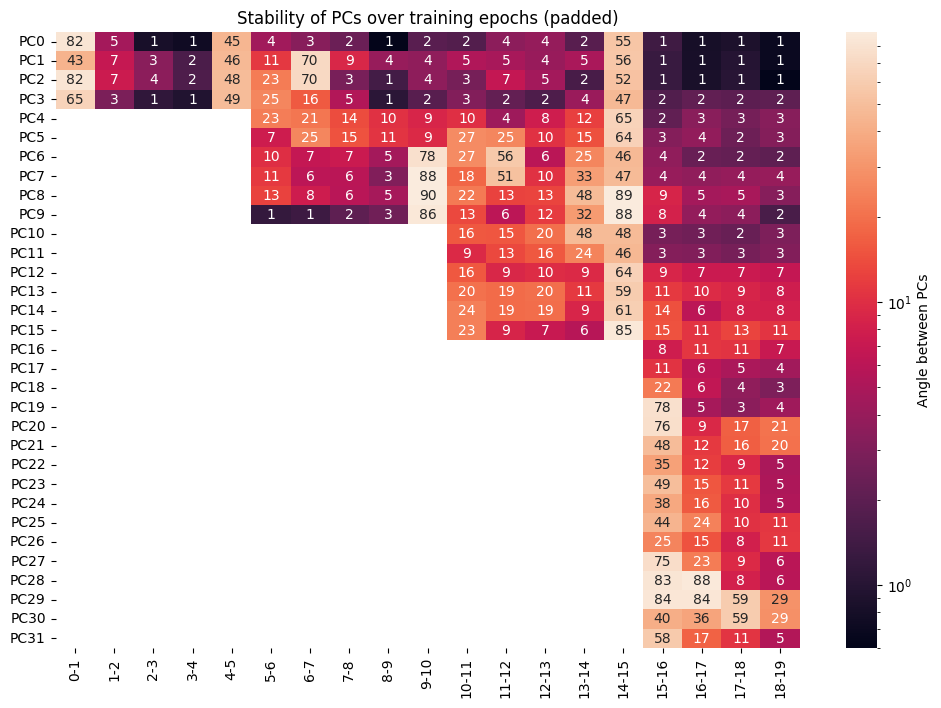

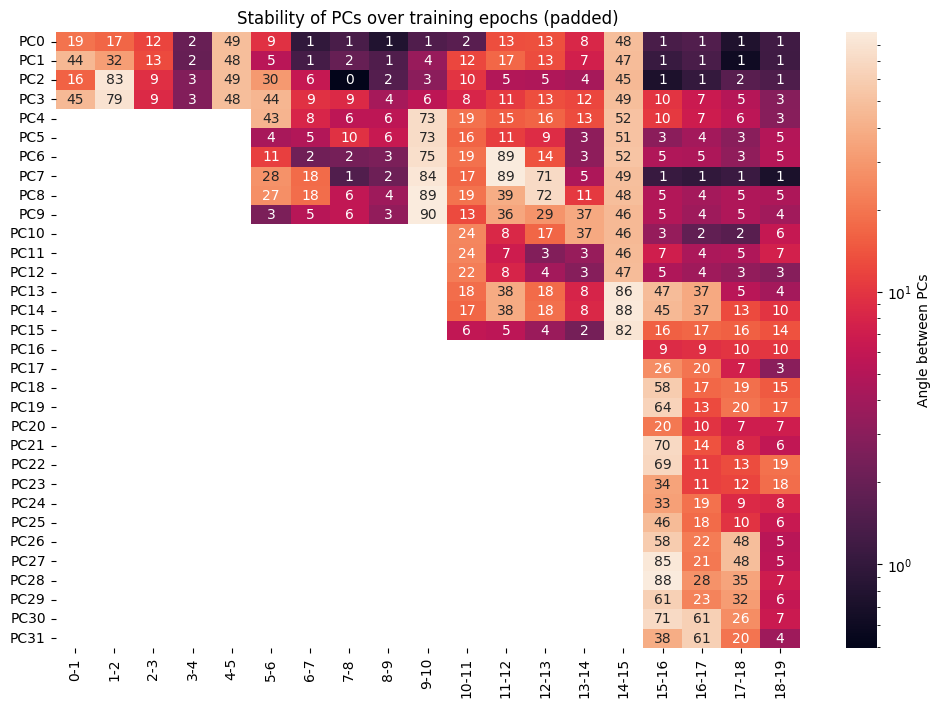

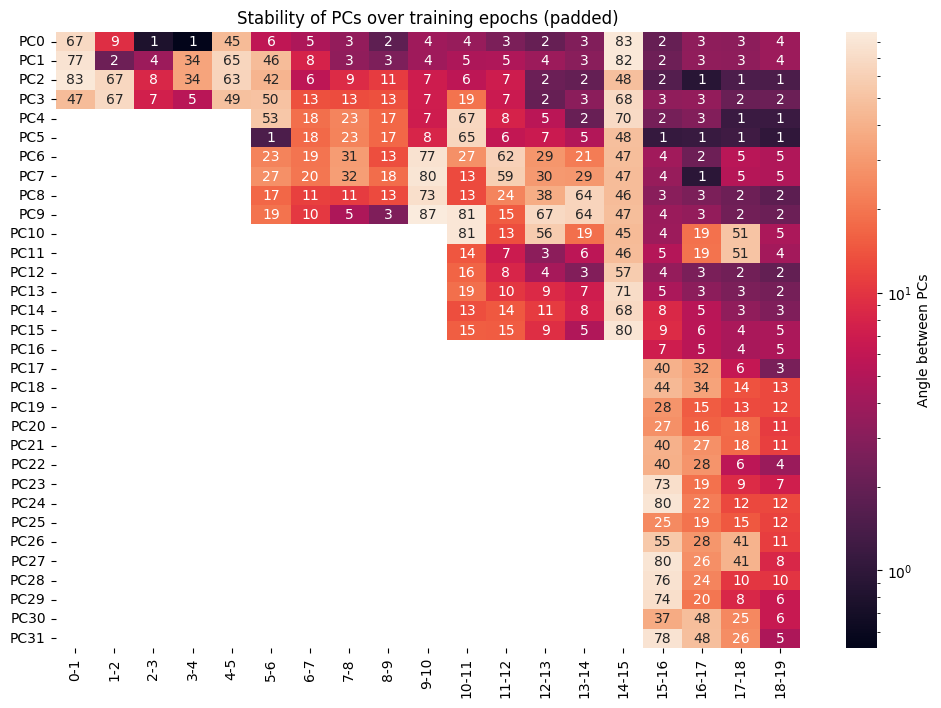

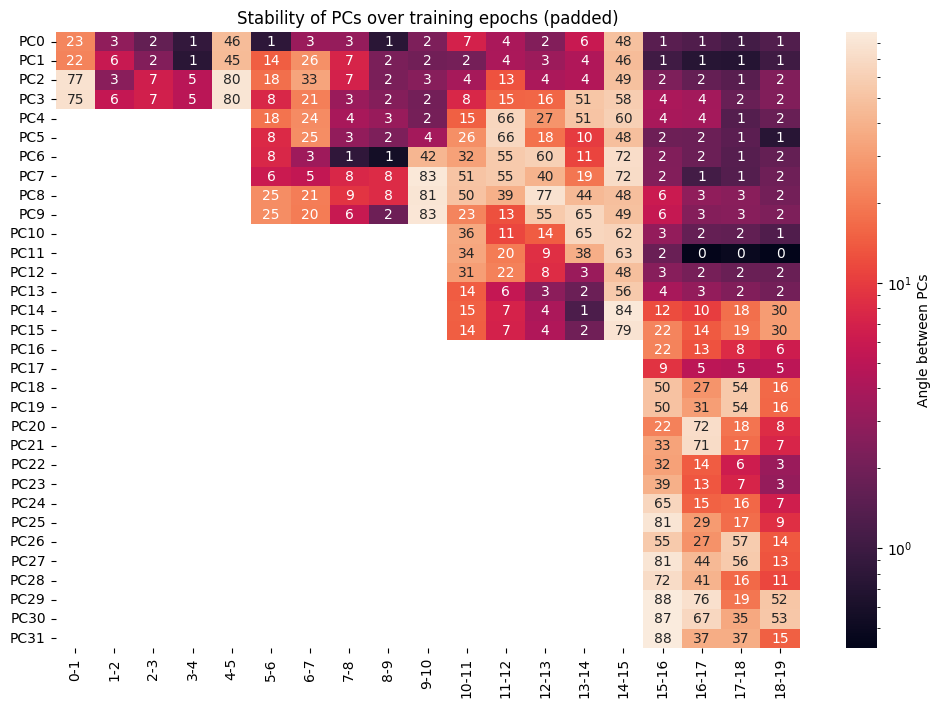

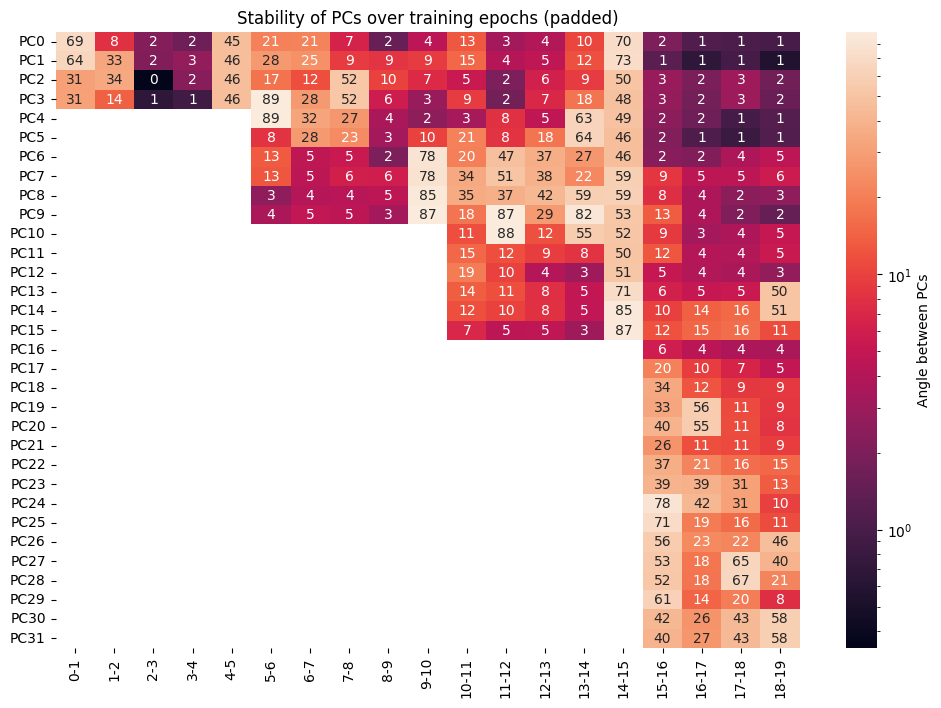

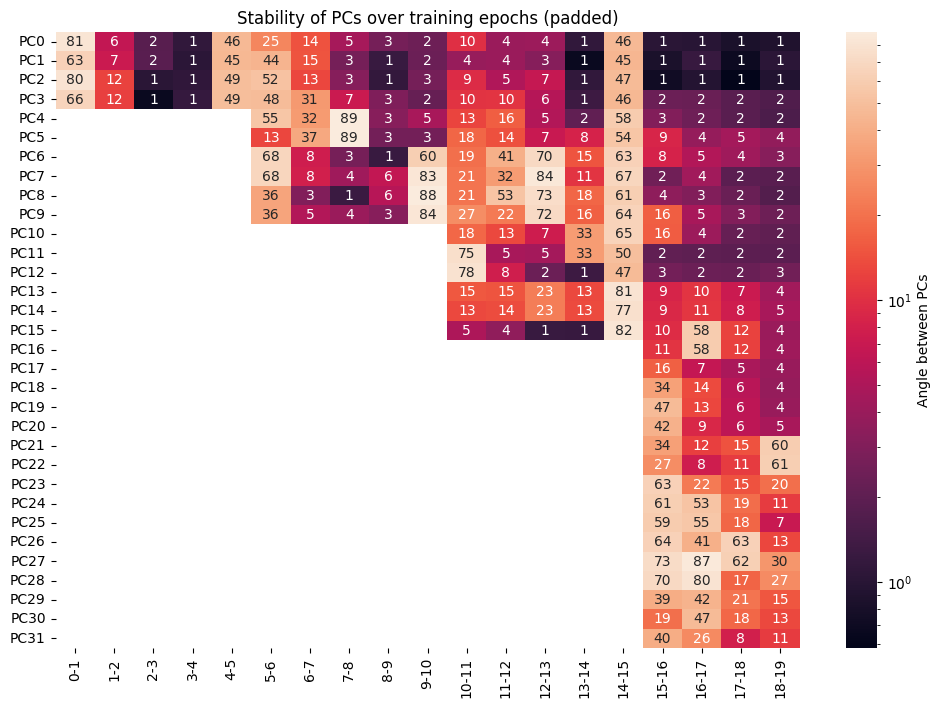

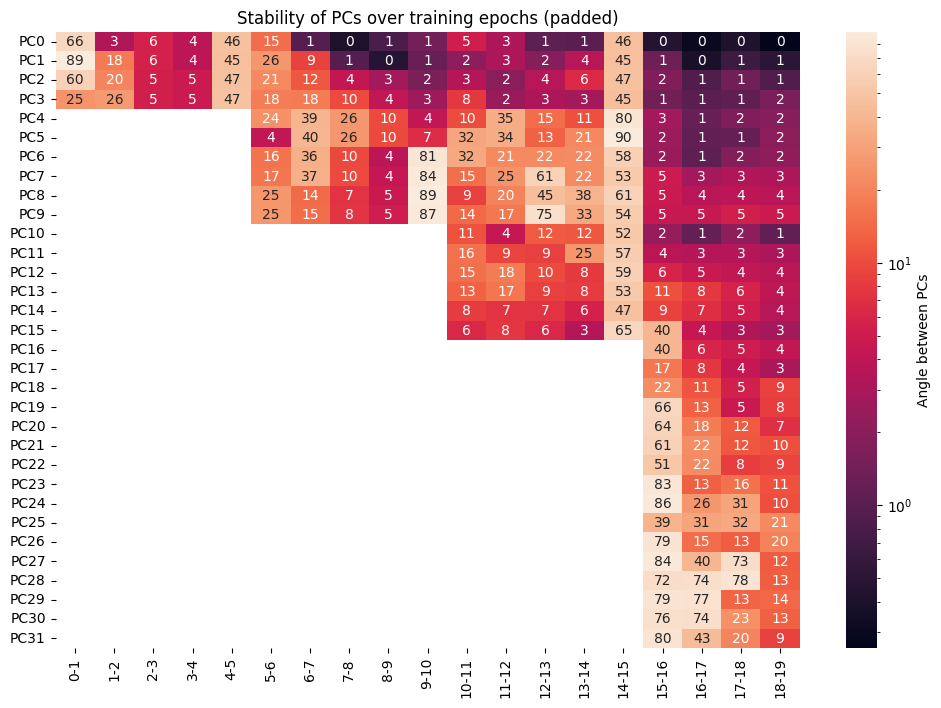

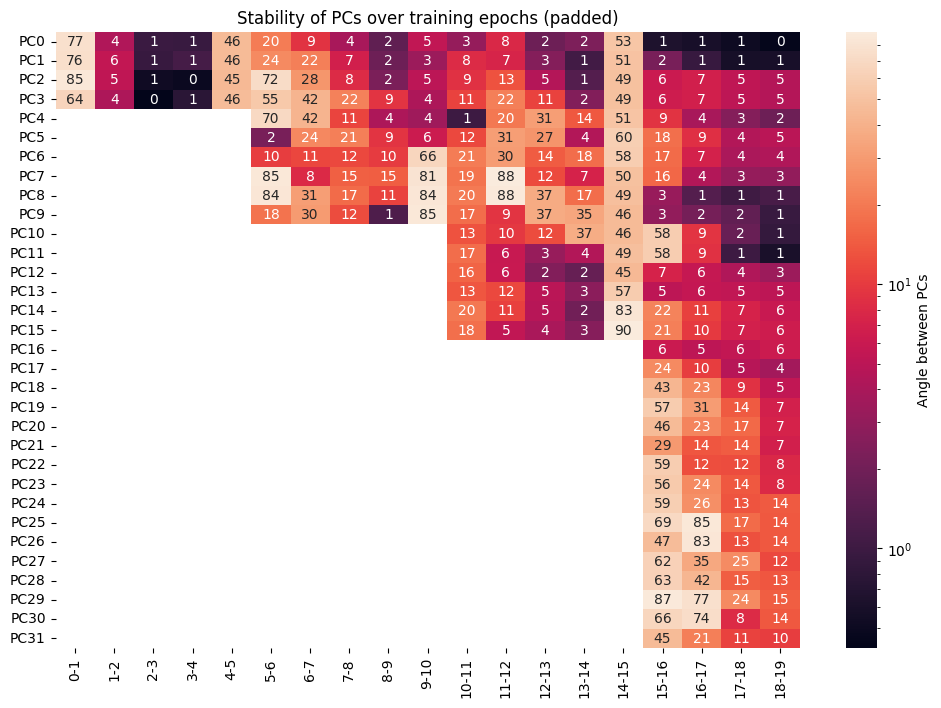

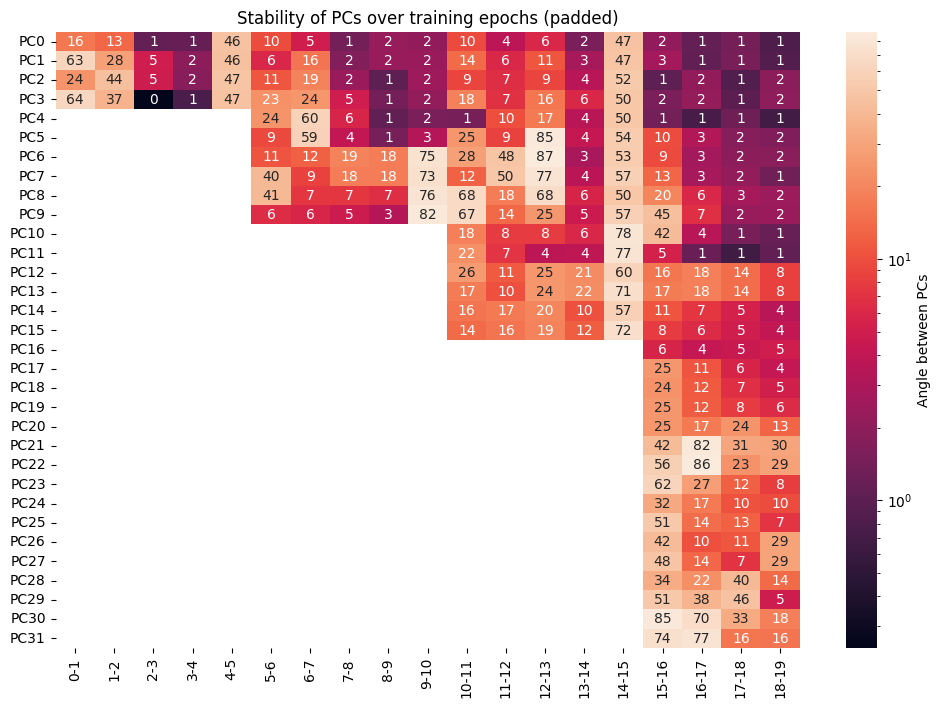

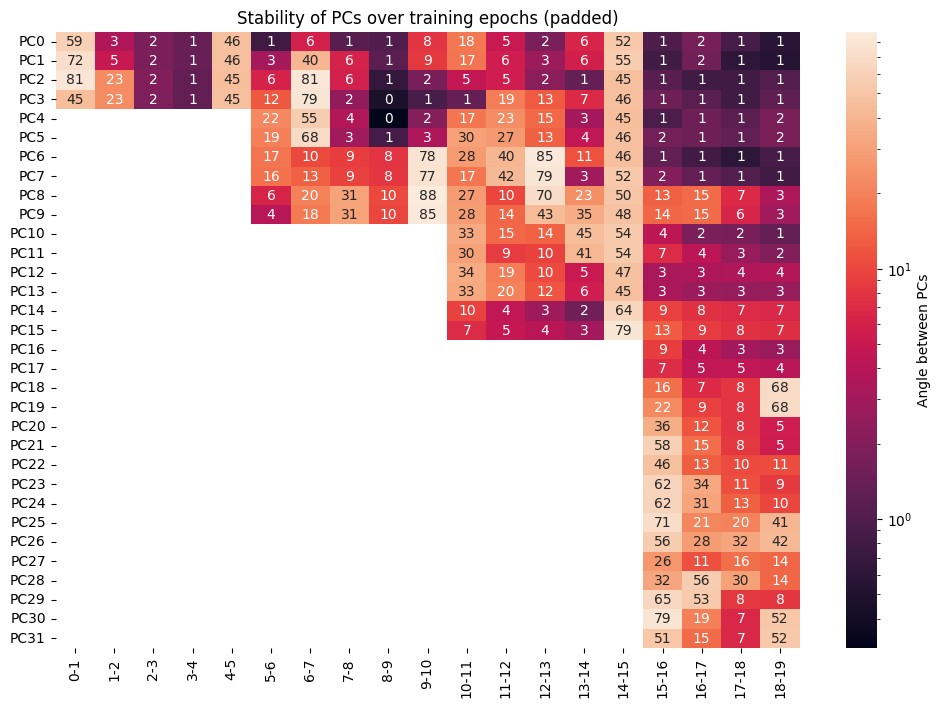

In [25]:
for k in range(10):
    model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)
    device = torch.device('cuda')

    n_epochs = 20
    d_explained_variance_ratios = []
    d_latent_matrices = []

    size_ls = [4,10,16,32]
    manner = 'cell_division'

    dev_train_vali_all_epochs(
        model,
        size_ls,
        manner,
        train_loader,
        test_loader,
        optimizer,
        n_epochs,
        device='cpu',
        save_path=save_path+'Dev/{}/'.format(manner)
        )
    
    padded_data = pad_latent_matrices(d_latent_matrices, 32)
    padded_angle_dict = angle_between_pcs(padded_data, all_epoch_pairs)
    plot_heatmap(padded_angle_dict, all_epoch_pairs, k)